In [1]:
# importing packages and modules
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

# code from summer project working with PWM data
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

sns.set_context("talk")

In [2]:
# list of animals that have good psychometrics
animalsIDs = ['W060','W068','W073','W074','W075','W080','W081','W082','W088','W089']
animalsCurrent = ['W068','W075','W080','W081','W089']

In [3]:
pni_path = '/Users/lencacuturela/Desktop/github/LC_PWM_GLM-HMM/data'
laptop_path = '/Users/lencacuturela/Desktop/Research/github/LC_PWM_GLM-HMM/data'

In [4]:
path = pni_path
x, y = io_utils.prepare_design_matrices(rat_id='W081', path=path, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W081', path=path, psychometric=True, cutoff=10, stage_filter=3))
N = x.shape[0]
C = 2 # classes
K = 1 # states
D = x.shape[1]

# Fitting a dGLM-HMM1 as check up

# dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
# initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
# checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(10**4, K, D), sessInd=sessInd, pi0=None, maxIter=400, tol=1e-4) # fit the model
# print(np.argmax(checkLl))

In [5]:
rat_id = 'W081'
path = pni_path
stage_filter=3
folds=5
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)
D = trainX[0].shape[1]
C = 2 # only looking at binomial classes

fold = 0
N = trainX[fold].shape[0]
oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
trainY[fold] = trainY[fold].astype(int)
testY[fold] = testY[fold].astype(int)

# Fitting single dGLM-HMM1 for folds

# initP, initW = dGLM_HMM.generate_param(sessInd=trainSessInd[fold], transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
# allP,  allW, trainLl = dGLM_HMM.fit(trainX[fold], trainY[fold],  initP, initW, sigma=reshapeSigma(10**5, K, D), sessInd=trainSessInd[fold], pi0=None, maxIter=400, tol=1e-3, penaltyW=True) # fit the model

### Fitting multiple initializations for sigma = 0.1 from previous sigma fitted parameters + adding noise

In [12]:
rat_id = 'W075'
inits = 3
stage_filter = 3
folds = 4
fold = 0
penaltyW=True
maxiter = 10


path = laptop_path
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)

D = trainX[0].shape[1]
C = 2 # only looking at binomial classes
K = 2

prevP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf=3_{K}_state_fold-0_multiple_sigmas_penaltyW=True.npy')
prevW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf=3_{K}_state_fold-0_multiple_sigmas_penaltyW=True.npy')
N = trainX[fold].shape[0]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
trainY[fold] = trainY[fold].astype(int)
testY[fold] = testY[fold].astype(int)

allP = np.zeros((inits, K, K))
allW = np.zeros((inits, N, K, D, C))
allLl = np.zeros((inits, maxiter))
testLl = np.zeros((inits))

for i in range(0,inits):
    print("Init ", i)
    noiseP0, noiseW0 = dGLM_HMM.generate_param(sessInd=trainSessInd[fold], transitionDistribution=['dirichlet', (10, 1)], weightDistribution=['uniform', (-1,1)]) # initial random param
    # two different ways of intializing P 
    if (i==0):
        initP = prevP[4]
    elif (i%2 == 0):
        initP = (noiseP0 + prevP[4]) / 2
    else:
        initP = noiseP0
    print(initP)
    initW = noiseW0 + prevW[4]
    allP[i], allW[i], allLl[i] = dGLM_HMM.fit(trainX[fold], trainY[fold],  initP, initW, sigma=reshapeSigma(0.1, K, D), sessInd=trainSessInd[fold], pi0=None, maxIter=maxiter, tol=1e-3, penaltyW=True) # fit the model
        
    # evaluate
    sess = len(trainSessInd[fold]) - 1 # number sessions
    testPhi = dGLM_HMM.observation_probability(testX[fold], reshapeWeights(allW[i], trainSessInd[fold], testSessInd[fold]))
    for s in range(0, sess):
        # evaluate on test data for each session separately
        _, _, temp = dGLM_HMM.forward_pass(testY[fold][testSessInd[fold][s]:testSessInd[fold][s+1]],allP[i],testPhi[testSessInd[fold][s]:testSessInd[fold][s+1]])
        testLl[i] += temp
    
    testLl[i] = testLl[i] / testSessInd[fold][-1] # normalizing to the total number of trials in test dataset

    np.save(f'../data_PWM/trainLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}', allLl)
    np.save(f'../data_PWM/testLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}', testLl)
    np.save(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}', allP)
    np.save(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}', allW)


Init  0
[[0.77732676 0.22267324]
 [0.68260122 0.31739878]]
0
Init  1
[[0.96718045 0.03281955]
 [0.00703708 0.99296292]]
0
Init  2
[[0.84979071 0.15020929]
 [0.41802927 0.58197073]]
0


In [6]:
rat_id = 'W075'
inits = 30
stage_filter = 3
folds = 4
fold = 0
penaltyW=True
maxiter = 250

C = 2 # only looking at binomial classes
K = 2

# Loading what was fit in the above cell (files on laptop)

# allLl = np.load(f'../data_PWM/trainLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}.npy')
# testLl = np.load(f'../data_PWM/testLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}.npy')
# allP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}.npy')
# allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}.npy')

# x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)

# fig, axes = plt.subplots(1)
# print(find_top_init_plot_loglikelihoods(ll,maxdiff,ax=None,startix=5,plot=True))

### Global Optimal solutions found from standard GLM-HMM fitting (in PWM_GLM-HMM) with 4 animals put together and multiple initializations
(checked that top solutions are consistent in parameters and they are the same ones found with Iris' code)
### and used now for initialization model with sigma=0.1

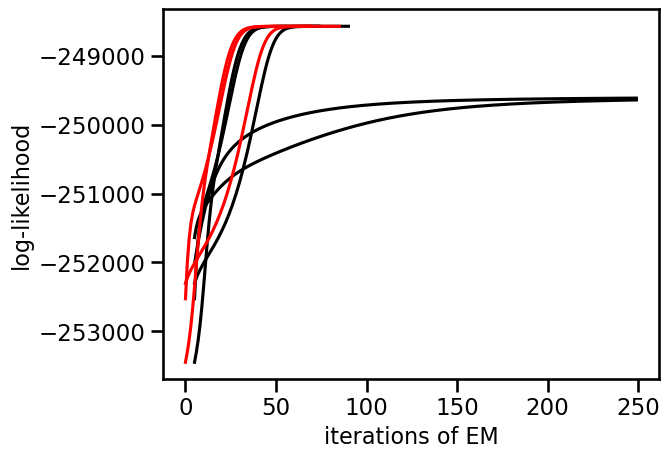

In [4]:
# Loading 
tempLl = np.load('../data_PWM/trainLl-global_PWM_all-animals_sf=4_2_state_multiple_inits_L2penaltyW=1.npy')
tempP = np.load('../data_PWM/P-global_PWM_all-animals_sf=4_2_state_multiple_inits_L2penaltyW=1.npy')
tempW = np.load('../data_PWM/W-global_PWM_all-animals_sf=4_2_state_multiple_inits_L2penaltyW=1.npy')
fig, axes = plt.subplots(1)
bestInd, topInd = find_top_init_plot_loglikelihoods(tempLl[0:5],maxdiff=100,ax=axes,startix=5,plot=True)

In [5]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
nfolds = 4

# for randInd in randomOrder:
#     animal = animalsIDs[randInd]
for K in [2,1]:
    glmhmmP = np.load(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')[bestInd]
    glmhmmW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')[bestInd]
    print(glmhmmW.shape)
    for animal in ['W075','W081','W060']:
        print("Animal ", animal)
        trainLl, testLl, allP, allW = fit_eval_CV_multiple_sigmas_PWM(rat_id=animal, stage_filter=3, K=K, folds=nfolds, sigmaList = sigmaList, maxiter=300, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=1, path=pni_path, save=True)


(489249, 2, 6, 2)
Animal  W075
Sigma Index 0
GLM HMM BEST INIT
Sigma Index 1
0


In [5]:
print(tempW[bestInd].shape)

(489249, 2, 6, 2)


In [9]:
# Checking that parameters are consistent across top matching indices

# oneSessInd = np.arange(0, tempW[0].shape[0],300)
# for ind in topInd:
#     print(tempP[ind])
#     fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(26,11))
#     fig.suptitle(f'Weights for 4 animals with {K} states & sigma=0')
#     fig.tight_layout()
#     axes[0,0].set_ylim(-2.2,2.2)
#     axes[1,0].set_ylim(-2.2,2.2)
#     axes[0,1].set_ylim(-2.2,2.2)
#     axes[1,1].set_ylim(-2.2,2.2)
#     plotting_weights_PWM(w=tempW[ind], sessInd=oneSessInd, axes=axes, sessStop=None, title=f'Weights for 4 animals with {K} states & sigma=0', save_fig=False)


(13, 100835, 2, 6, 2)


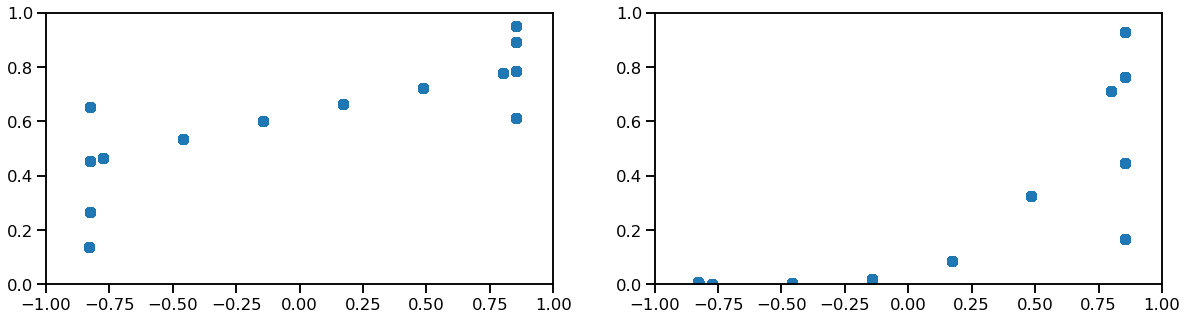

In [98]:
def psychometric(Wt, xt):
    ''' 

    calculating psychometric function based on bias, stimulus 1, and stimulus 2 

    Parameters
    ----------
    Wt: D x C numpy array
        matrix of weights at a certain time
    xt: D x 1 numpy vector
        features at a certain time
    Returns
    -------
    beta: T x k numpy array 
    matrix of backward conditional probabilities p(y_t+1:T | z_t) / p(y_t+1:T | y_1:t)
        

    '''
    K = Wt.shape[0]
    D = Wt.shape[1]
    C = Wt.shape[2]

    return softplus_deriv(-Wt[:,:,1].T@xt)

def plot_psychometric_per_state(Wt, x, axes):
    ''' 

    calculating psychometric function based on bias, stimulus 1, and stimulus 2 

    Parameters
    ----------
    Wt: K x C numpy array
        matrix of weights at a certain time
    xt: N x 3 numpy vector
        features across time for bias, stim A, stim B in this order
    Returns
    -------
    beta: T x k numpy array 
    matrix of backward conditional probabilities p(y_t+1:T | z_t) / p(y_t+1:T | y_1:t)
        

    '''
    K = Wt.shape[0]
    D = Wt.shape[1]
    deltaStim = x[:,1]-x[:,2]
    
    for k in range(0,K):
        psych = np.array([softplus_deriv(-Wt[k,:]@x[t]) for t in range(0,x.shape[0])])
        axes[k].scatter(deltaStim, psych)
        axes[k].set_xlim(-1,1)
        axes[k].set_ylim(0,1)
fig, axes = plt.subplots(1,2, figsize=(20,5))
allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
print(allW.shape)
plot_psychometric_per_state(allW[0,60000,:,0:3,1], x[:,0:3], axes)

In [ ]:
# State-specific psycometric function for PWM

def psychometric_per_state(Wt, xt):
    ''' 

    calculating psychometric function based on bias, stimulus 1, and stimulus 2 

    Parameters
    ----------
    Wt: K x D x C numpy array
        matrix of weights at a certain time
    xt: D x 1 numpy vector
        features at a certain time
    Returns
    -------
    beta: T x k numpy array 
    matrix of backward conditional probabilities p(y_t+1:T | z_t) / p(y_t+1:T | y_1:t)
        

    '''
    K = Wt.shape[0]
    D = Wt.shape[1]
    C = Wt.shape[2]

    return softplus_deriv(-Wt[:,:,1].T@xt)




    df = load_and_wrangle(rat_id = rat_id, path=path, psychometric=True, cutoff="perf", overwrite=False)

    # s_b has to be fixed to 76, where psychometrics are calculated (because relative difference is not a good measure of performance)
    df = df[df["s_b"] == 76]
    df["s_a-s_b"] = df["s_a"] - df["s_b"]
    # check where psychometrics happen
    t = df[abs(df["s_a-s_b"]) < 8]
    if len(t.index) == 0:
        print("There are NO (s_b=76) psychometrics for animal " + str(rat_id))
        return
    else:
        
        val_x = list(set(df["s_a-s_b"].tolist()))
        val_y = []
        var_y = []
        for diff in val_x:
            temp = df[df["s_a-s_b"] == diff].index.tolist()

            sum = []
            for i in temp:
                sum.append(y[i]) 
            val_y.append(np.mean(sum))
            var_y.append(np.var(sum))


    if (plot == True):
        # # plot simulated vs real data
        # fig, ax = plt.subplots(1,1)
        # colors = np.array([[39,150,237],[237,107,32]])/255
        # visualize.plot_weights(w[:,1:].T,ax,style='.-',color=colors,label=['true w','recovered w'])
        # colors = np.array([[39,110,167],[237,177,32]])/255
        # visualize.plot_weights(w_sim[:,1:].T,ax,style='.--',color=colors, label=['',''])
        # fig.suptitle("Rat " + str(rat_id))
        # ax.legend()
        
        val_x, val_y, var_y = calculate_psychometric(rat_id, y)
        _, sim_val_y, sim_var_y = calculate_psychometric(rat_id, sim_y)
        axes.errorbar(x=val_x, y=val_y, yerr=var_y, color="black", ls='none')
        # plt.errorbar(x=val_x, y=val_y_sim, yerr=var_y_sim, color="gray", ls='none') - similar variance to raw data
        sns.regplot(x=val_x, y=val_y, logistic=True, ci=None, color="black", ax=axes)
        sns.regplot(x=val_x, y=sim_val_y, logistic=True, ci=None, color="gray", ax=axes)
        axes.scatter(val_x, val_y, label = "data", color = "black")
        axes.scatter(val_x, sim_val_y, label = "model", color = "gray")
        axes.set_xticks([-8,0,8])
        axes.set_ylim(0,1)
        axes.legend(loc='upper left')
        if (save_fig==True):
            plt.savefig('figures/GLMHMM_SimulatedPsychoemtric_' + str(rat_id) + '_states-' + str(K), bbox_inches='tight', dpi=300)
            plt.show()

### Fitting mulitple initializations at the global fit first (sigma=0) - in PWM_GLM-HMM script

### Fitting dGLM-HMM1 for PWM data with K=1,2 and multiple sigmas value

In [5]:
randomOrder = np.array([6, 1, 9, 4, 5, 0, 7, 8, 3, 2])
print(randomOrder) # [6 1 9 4 5 0 7 8 3 2]

[6 1 9 4 5 0 7 8 3 2]


In [4]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
nfolds = 4

# for randInd in randomOrder:
#     animal = animalsIDs[randInd]
for K in [2,1]:
    for animal in ['W075','W081','W060']:
        print("Animal ", animal)
        glmhmmP = np.load(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')
        glmhmmW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')
        trainLl, testLl, allP, allW = fit_eval_CV_multiple_sigmas_PWM(rat_id=animal, stage_filter=3, K=K, folds=nfolds, sigmaList = sigmaList, maxiter=300, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=1, path=pni_path, save=True)

# new version of obs prob takes ... to fit 

Animal  W075


NameError: name 'pni_path' is not defined

In [24]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
nfolds = 4
trainLl, testLl, allP, allW = fit_eval_CV_multiple_sigmas_PWM(rat_id='W089', stage_filter=3, K=3, folds=nfolds, sigmaList = sigmaList, maxiter=300, penaltyW=True, path=laptop_path, save=True)


Sigma Index 0
0
100
200
Sigma Index 1
0
100
200
Sigma Index 2
0
100


KeyboardInterrupt: 

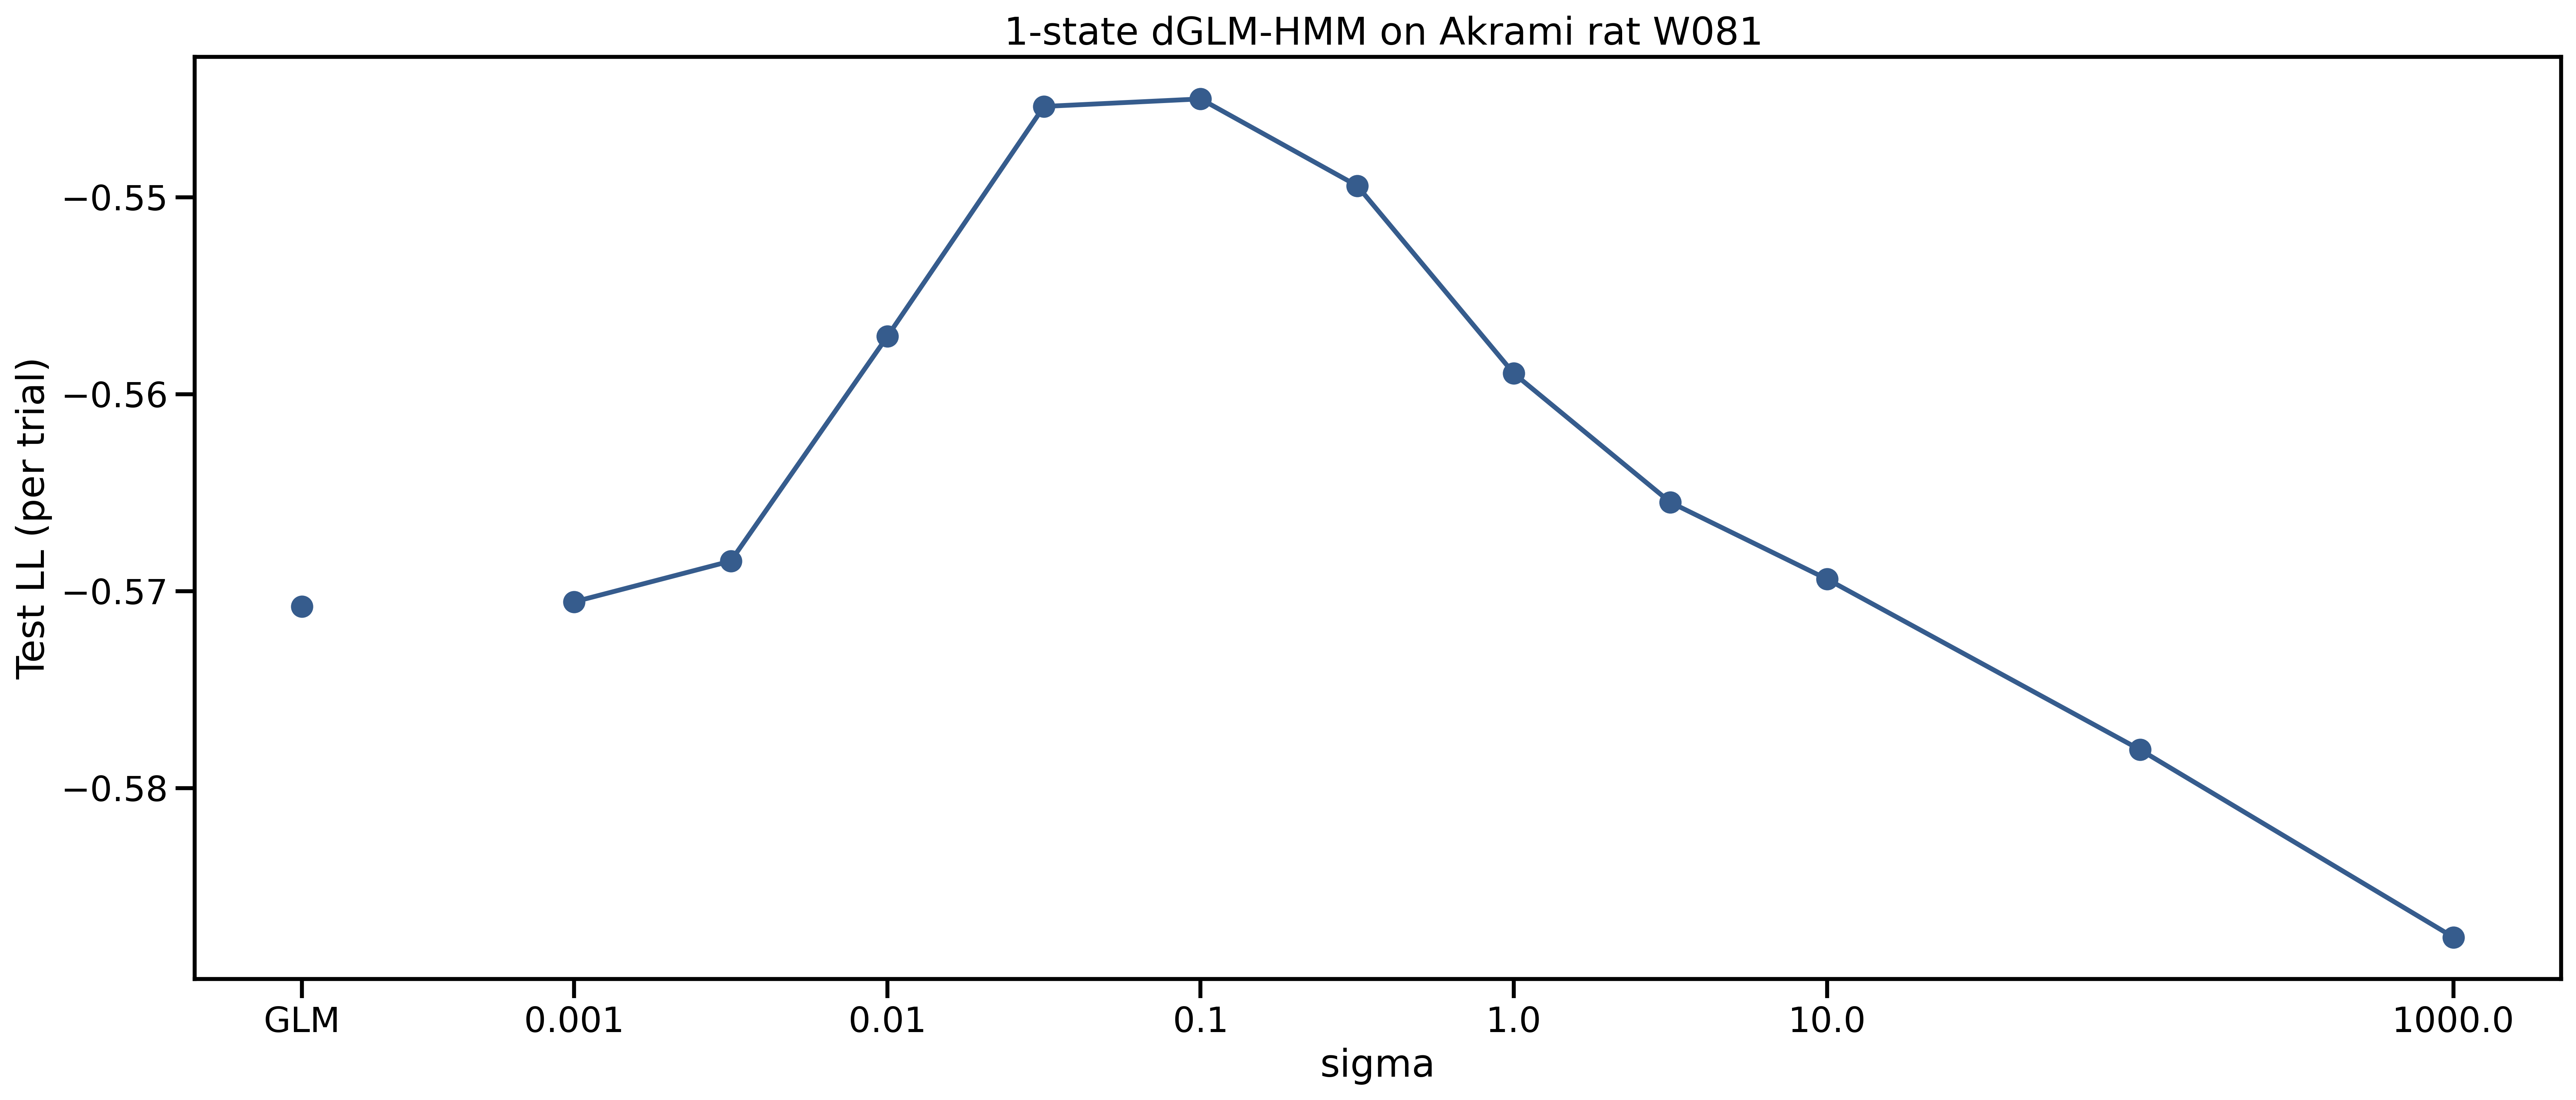

In [6]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))] 
nfolds = 4
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f' 1-state dGLM-HMM on Akrami rat W081', save_fig=True)

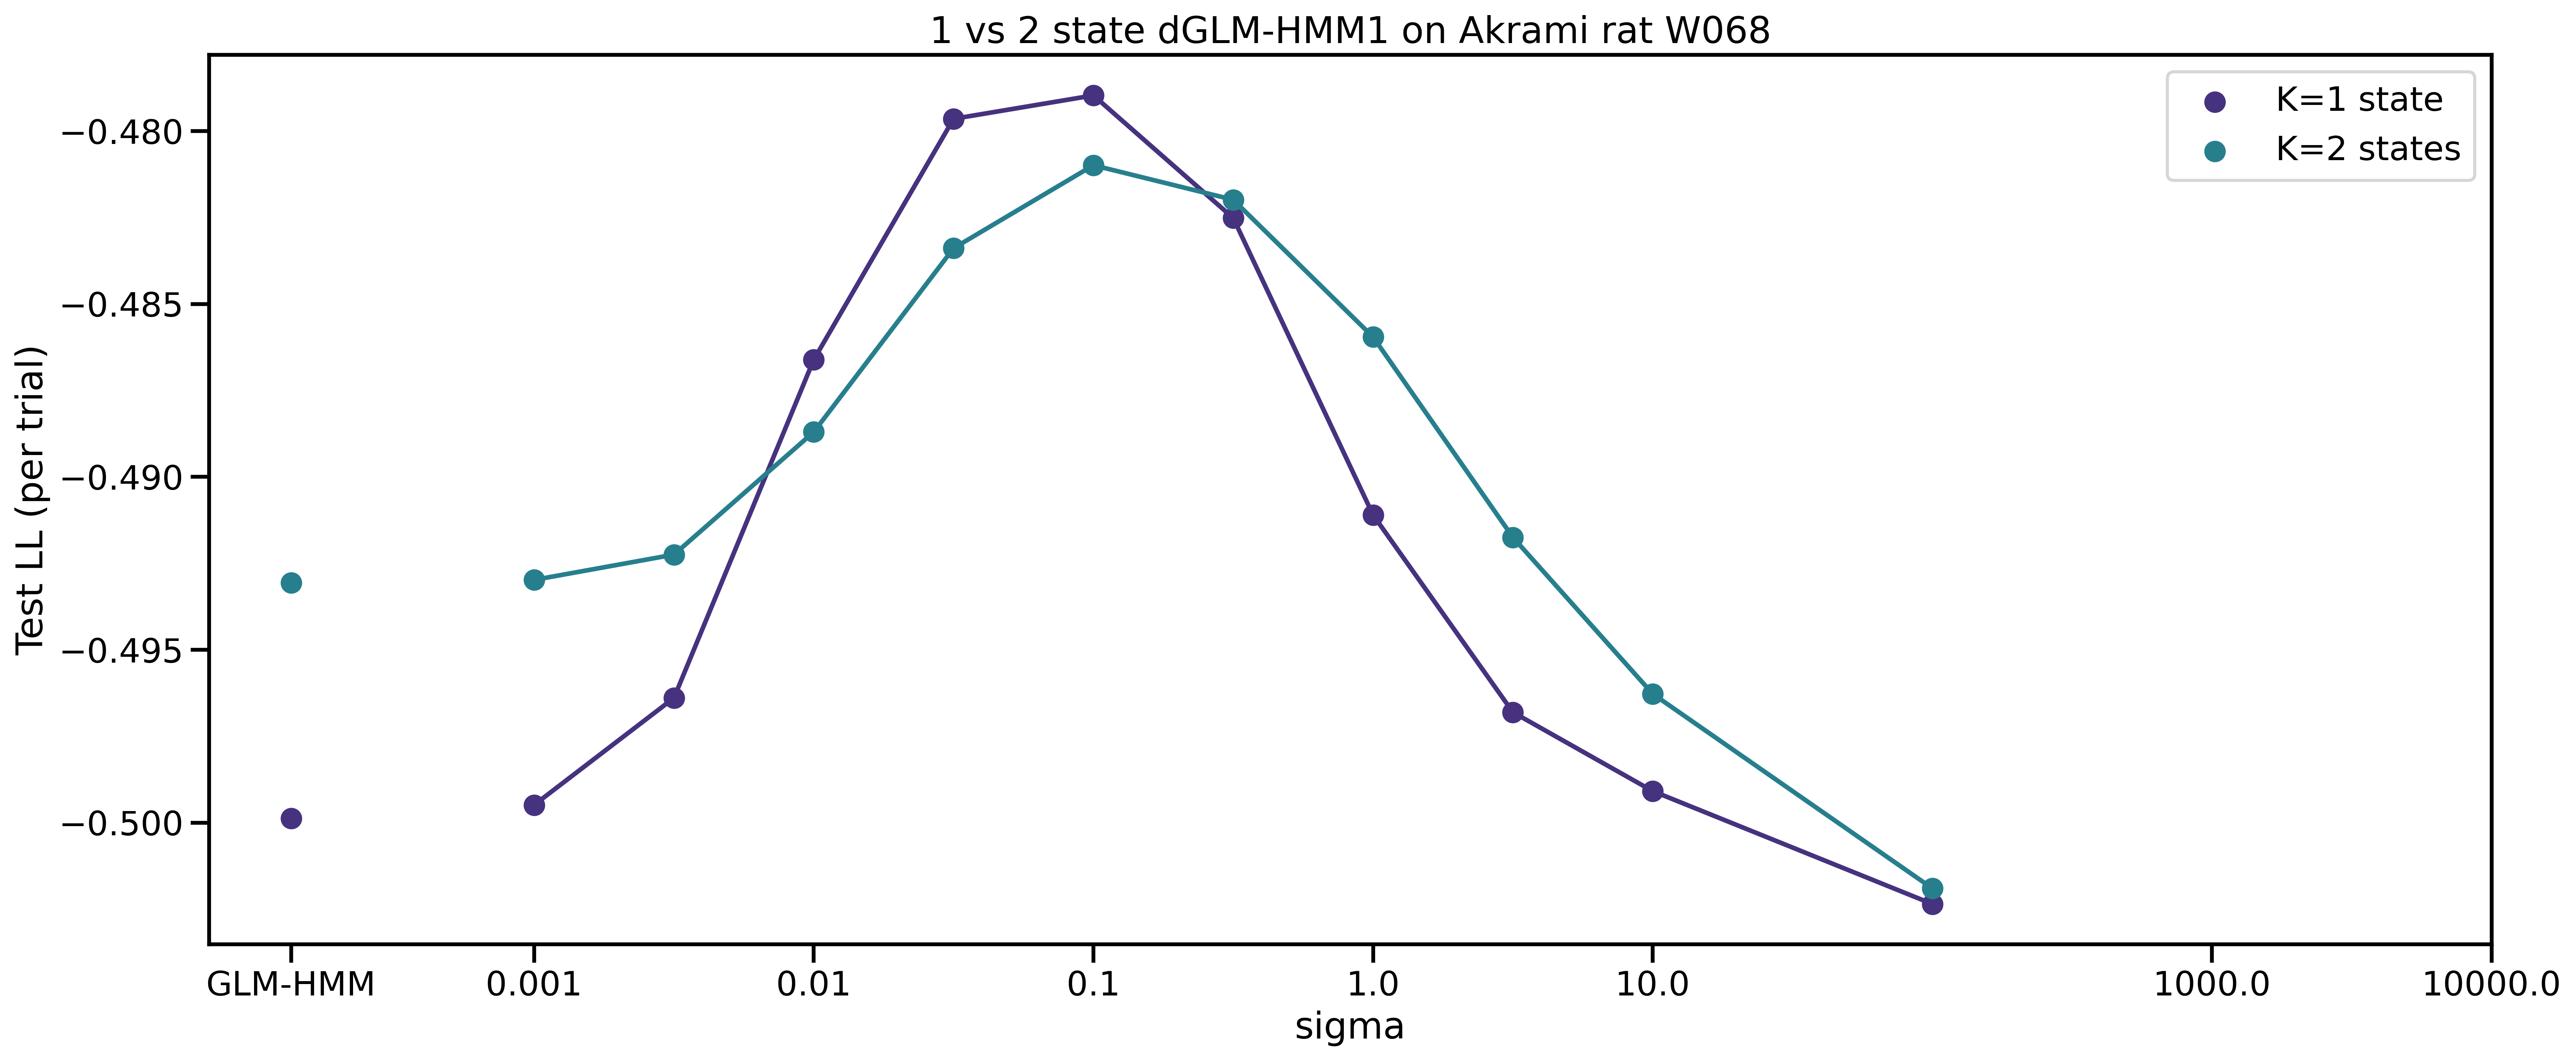

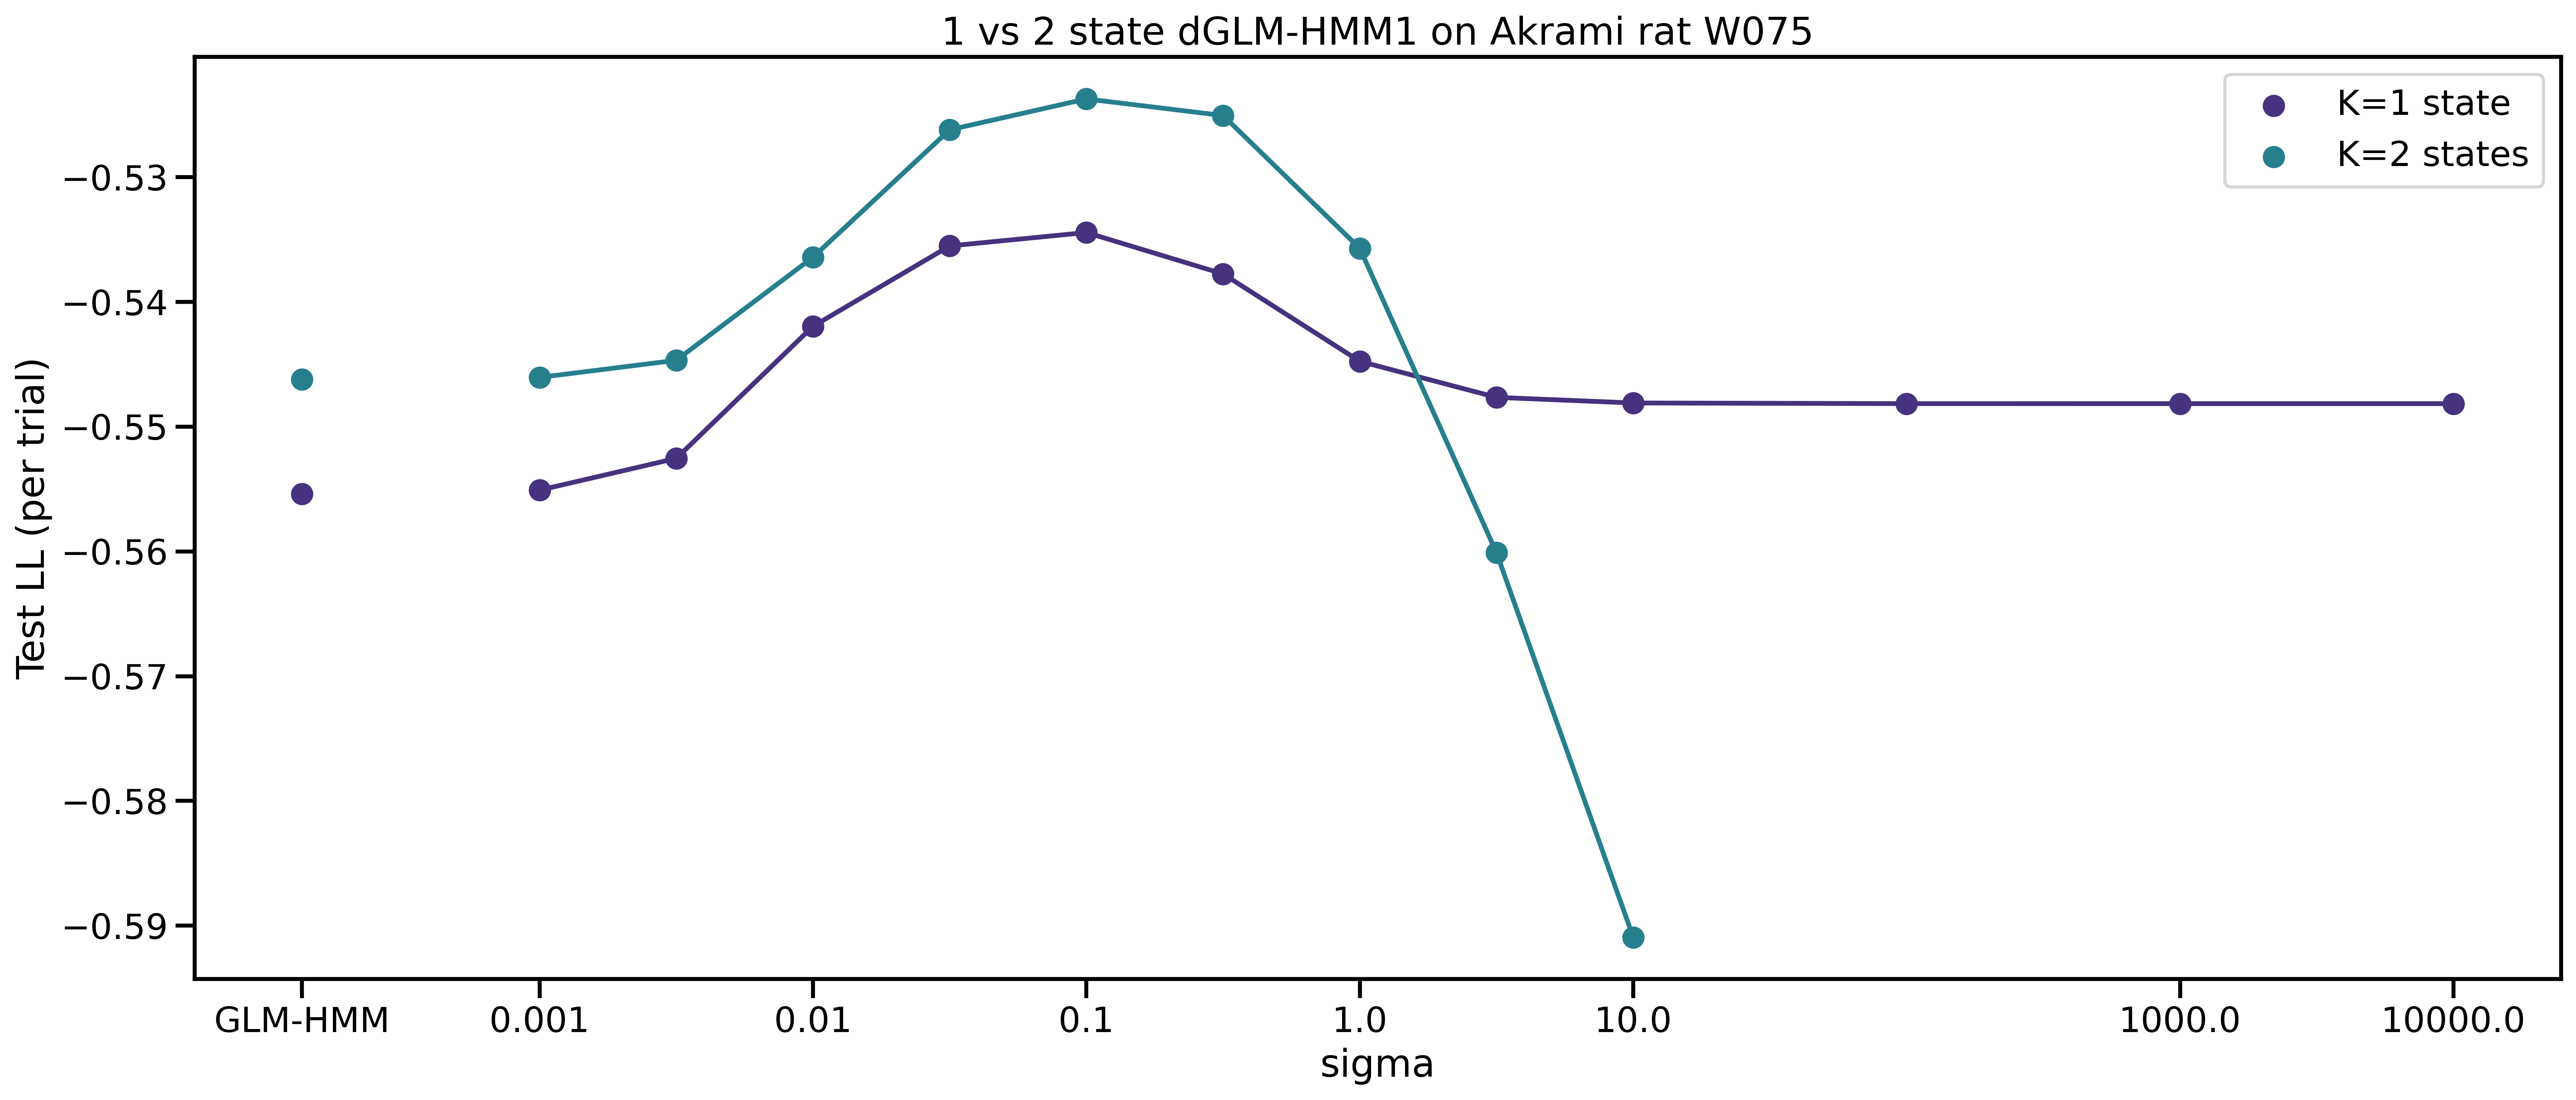

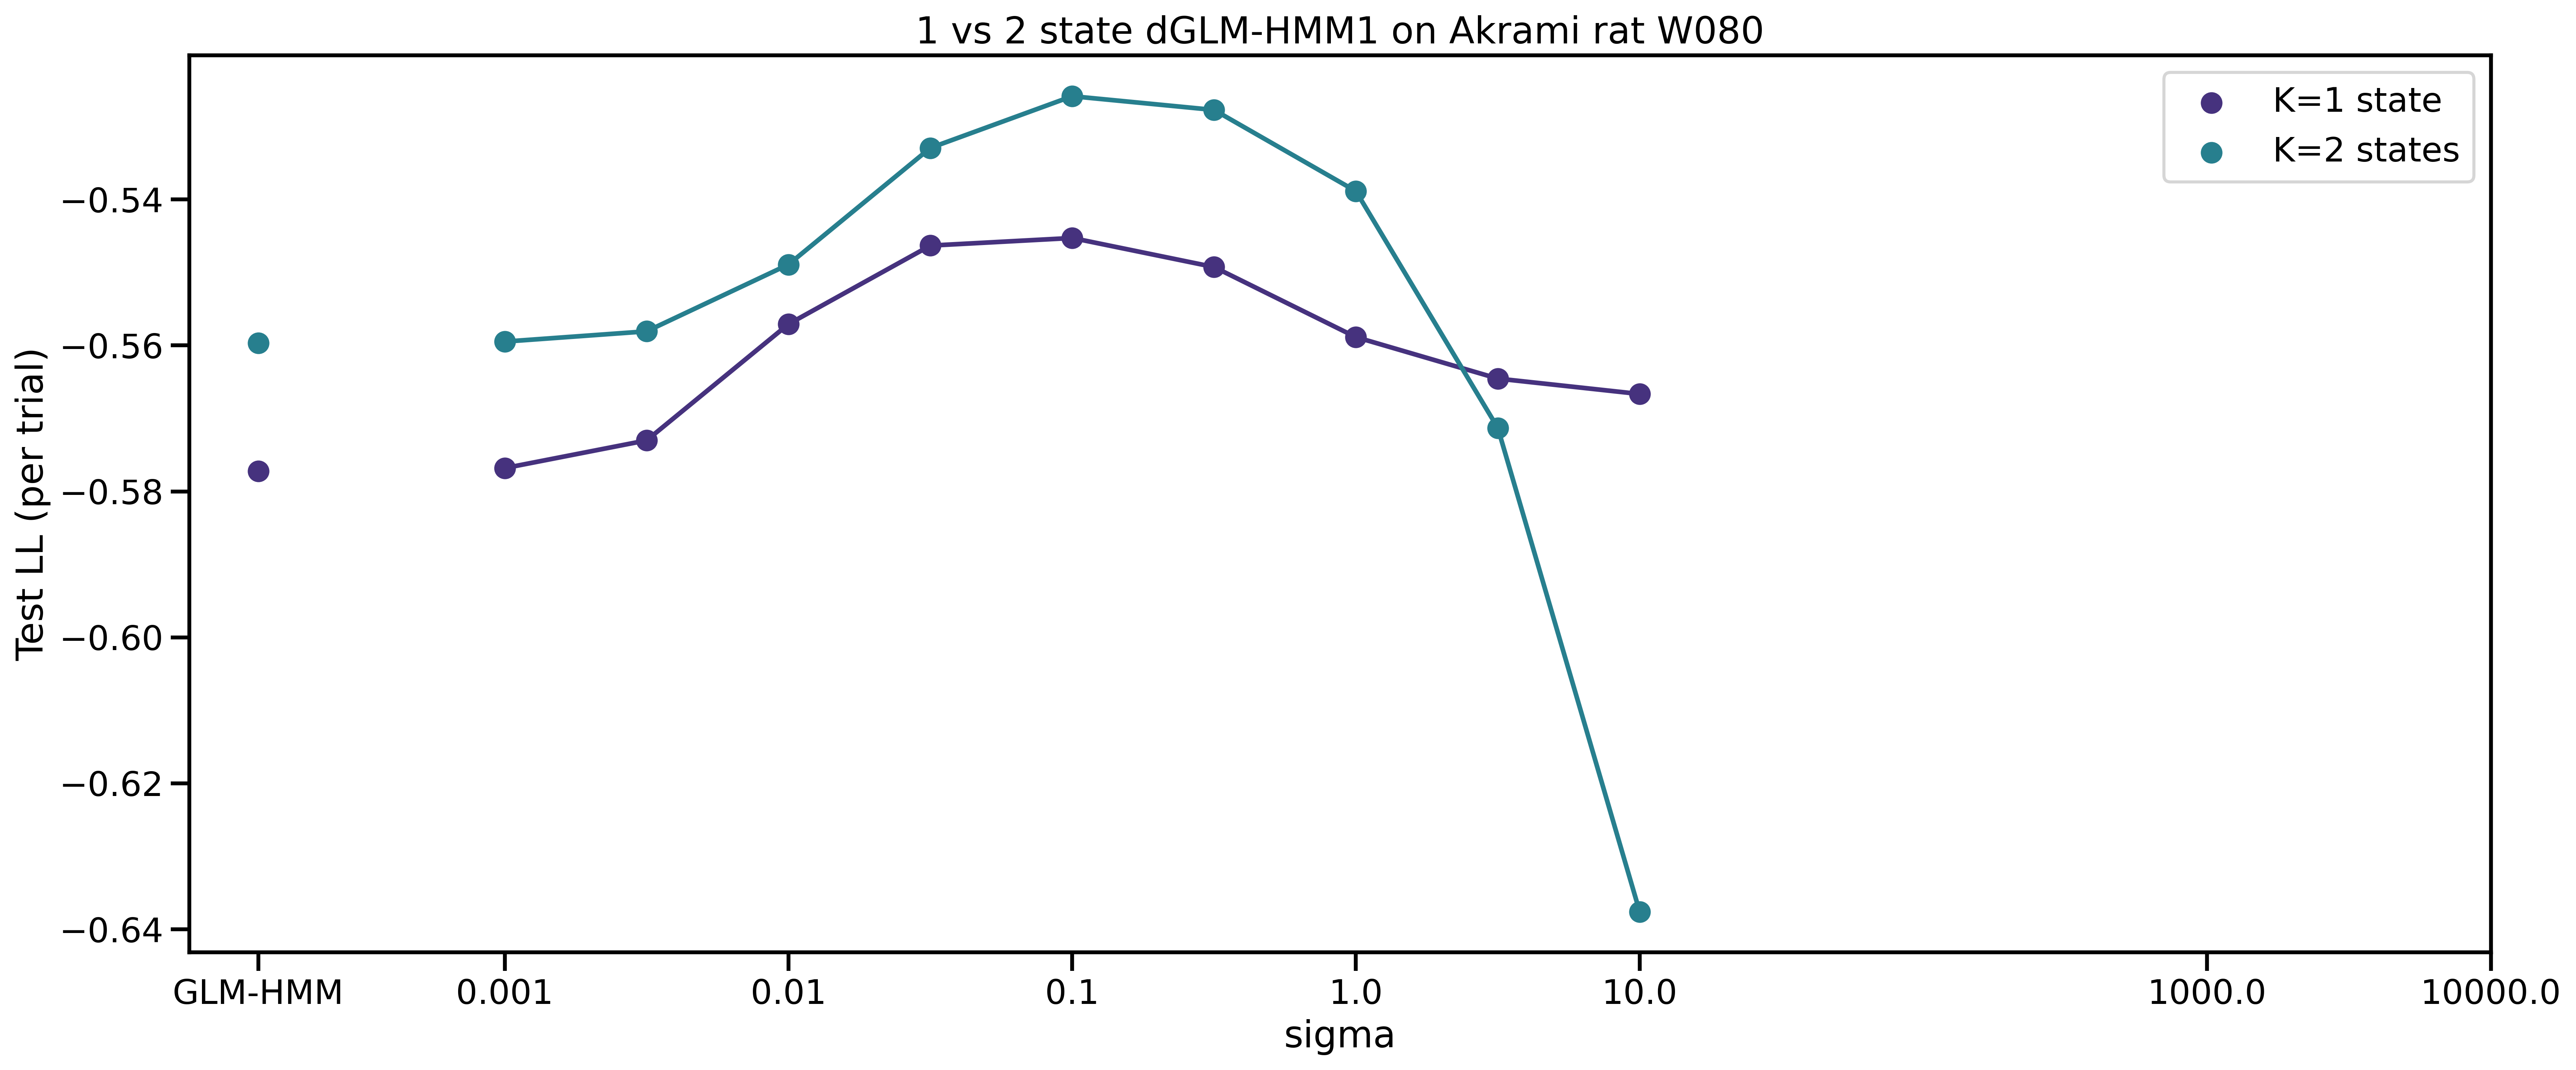

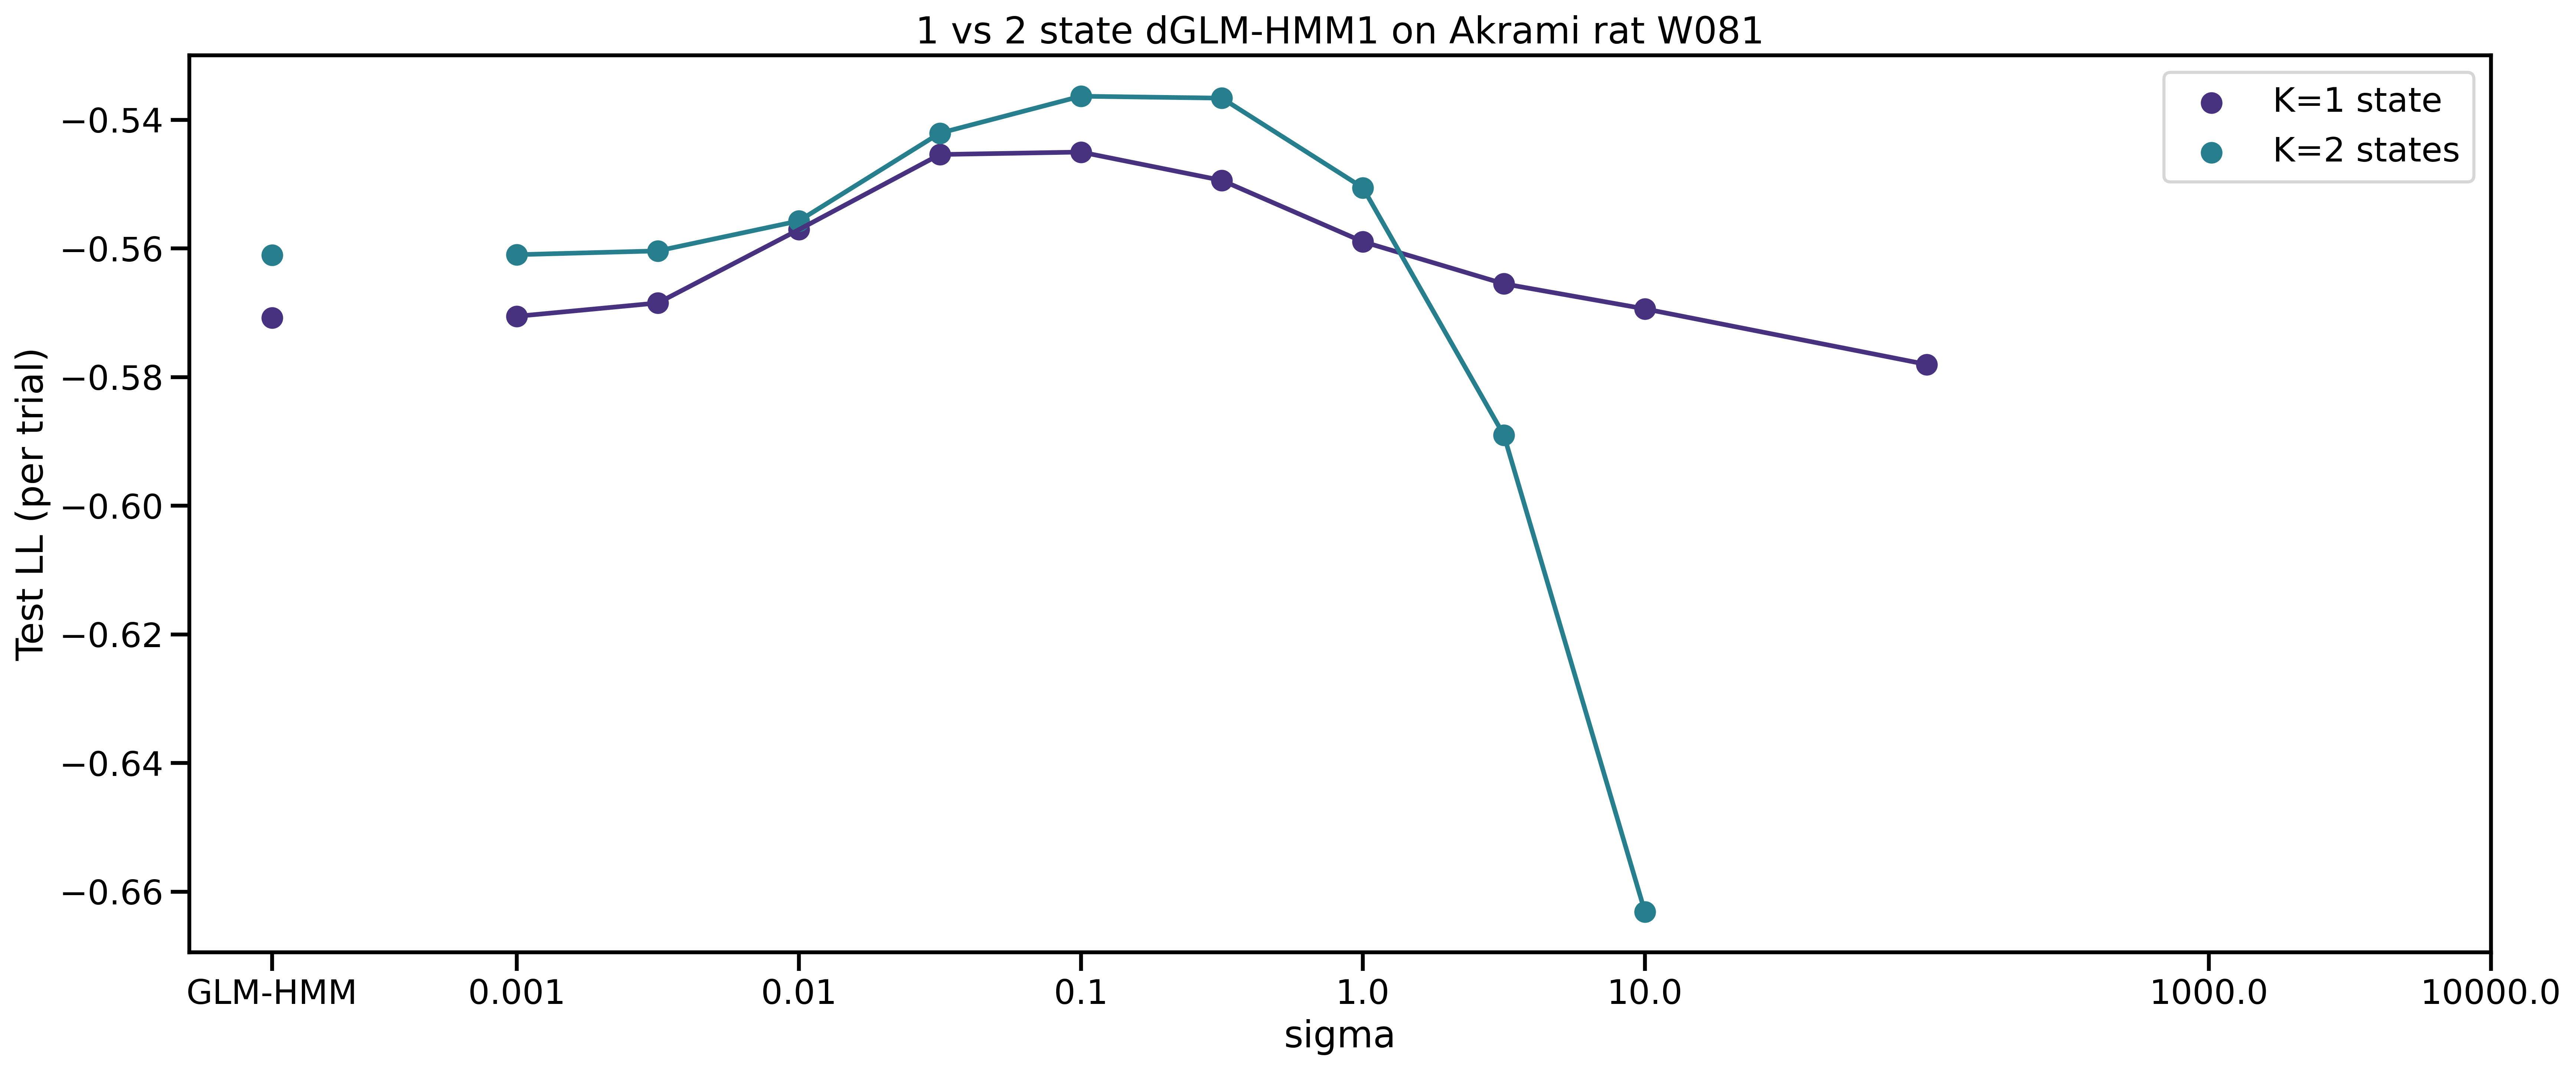

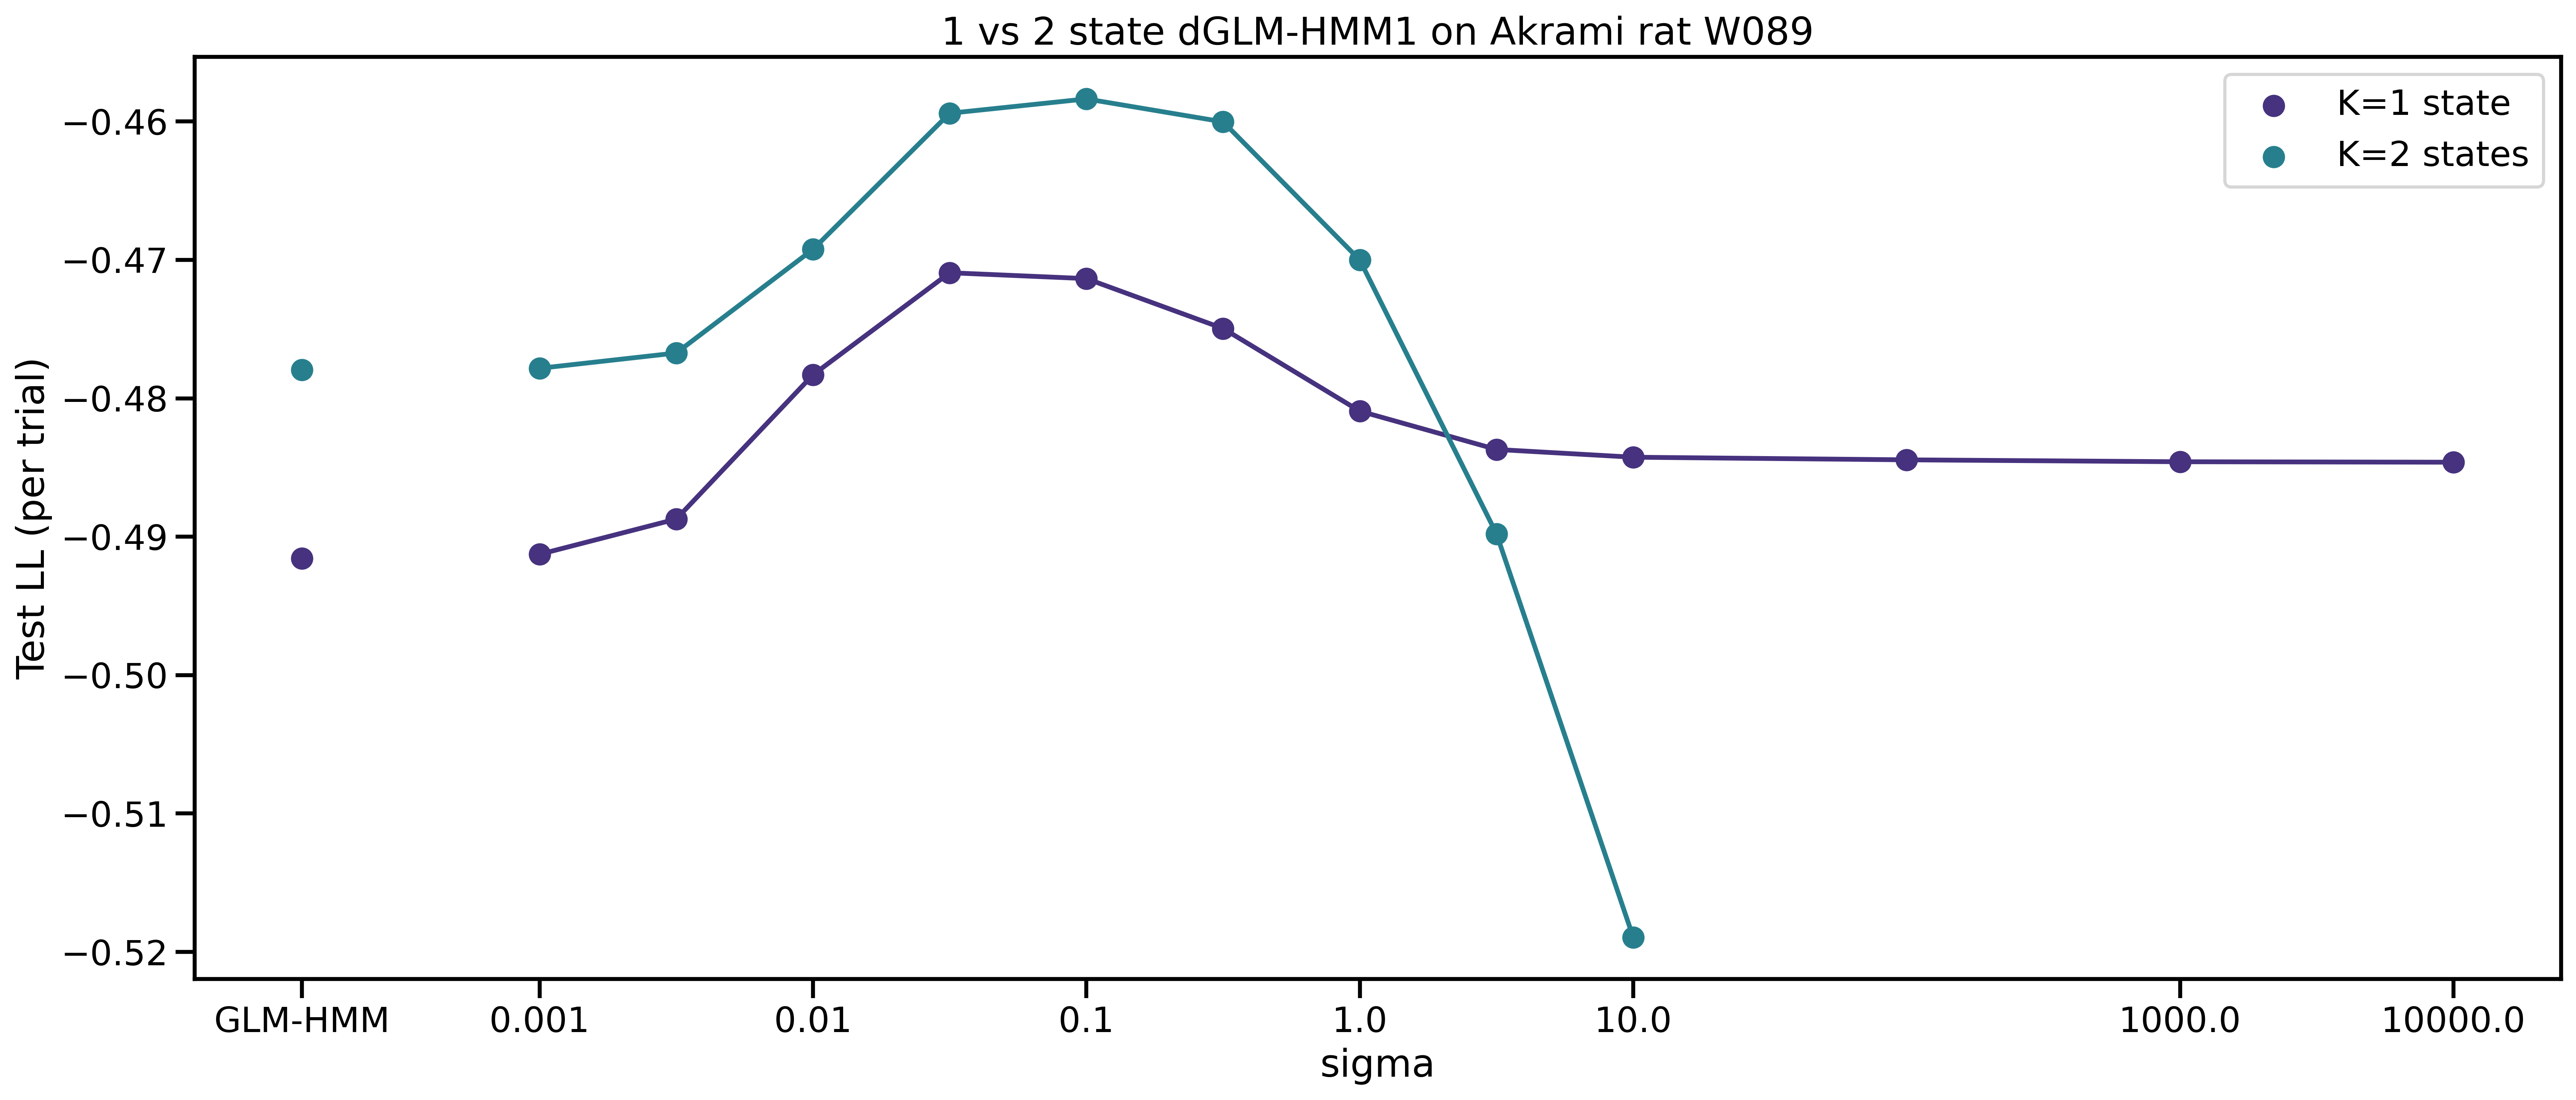

In [31]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# 1 vs 2 state test LL vs sigma for all animals
for animal in animalsCurrent:
    fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    sigma_CV_testLl_plot_PWM(rat_id=animal, stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat {animal}', labels=['K=1 state'], color=0, penaltyW=True, save_fig=False)
    sigma_CV_testLl_plot_PWM(rat_id=animal, stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat {animal}', labels=['K=2 states'], color=2, penaltyW=True, save_fig=True)

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(np.log(sigmaList[1:]), testLl[1:], '-o', color=colormap[color+fold], linestyle=linestyle, label=labels[fold])
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(np.log(sigmaList[1:]), testLl[1:], '-o', color=colormap[color+fold], linestyle=linestyle, label=labels[fold])
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will

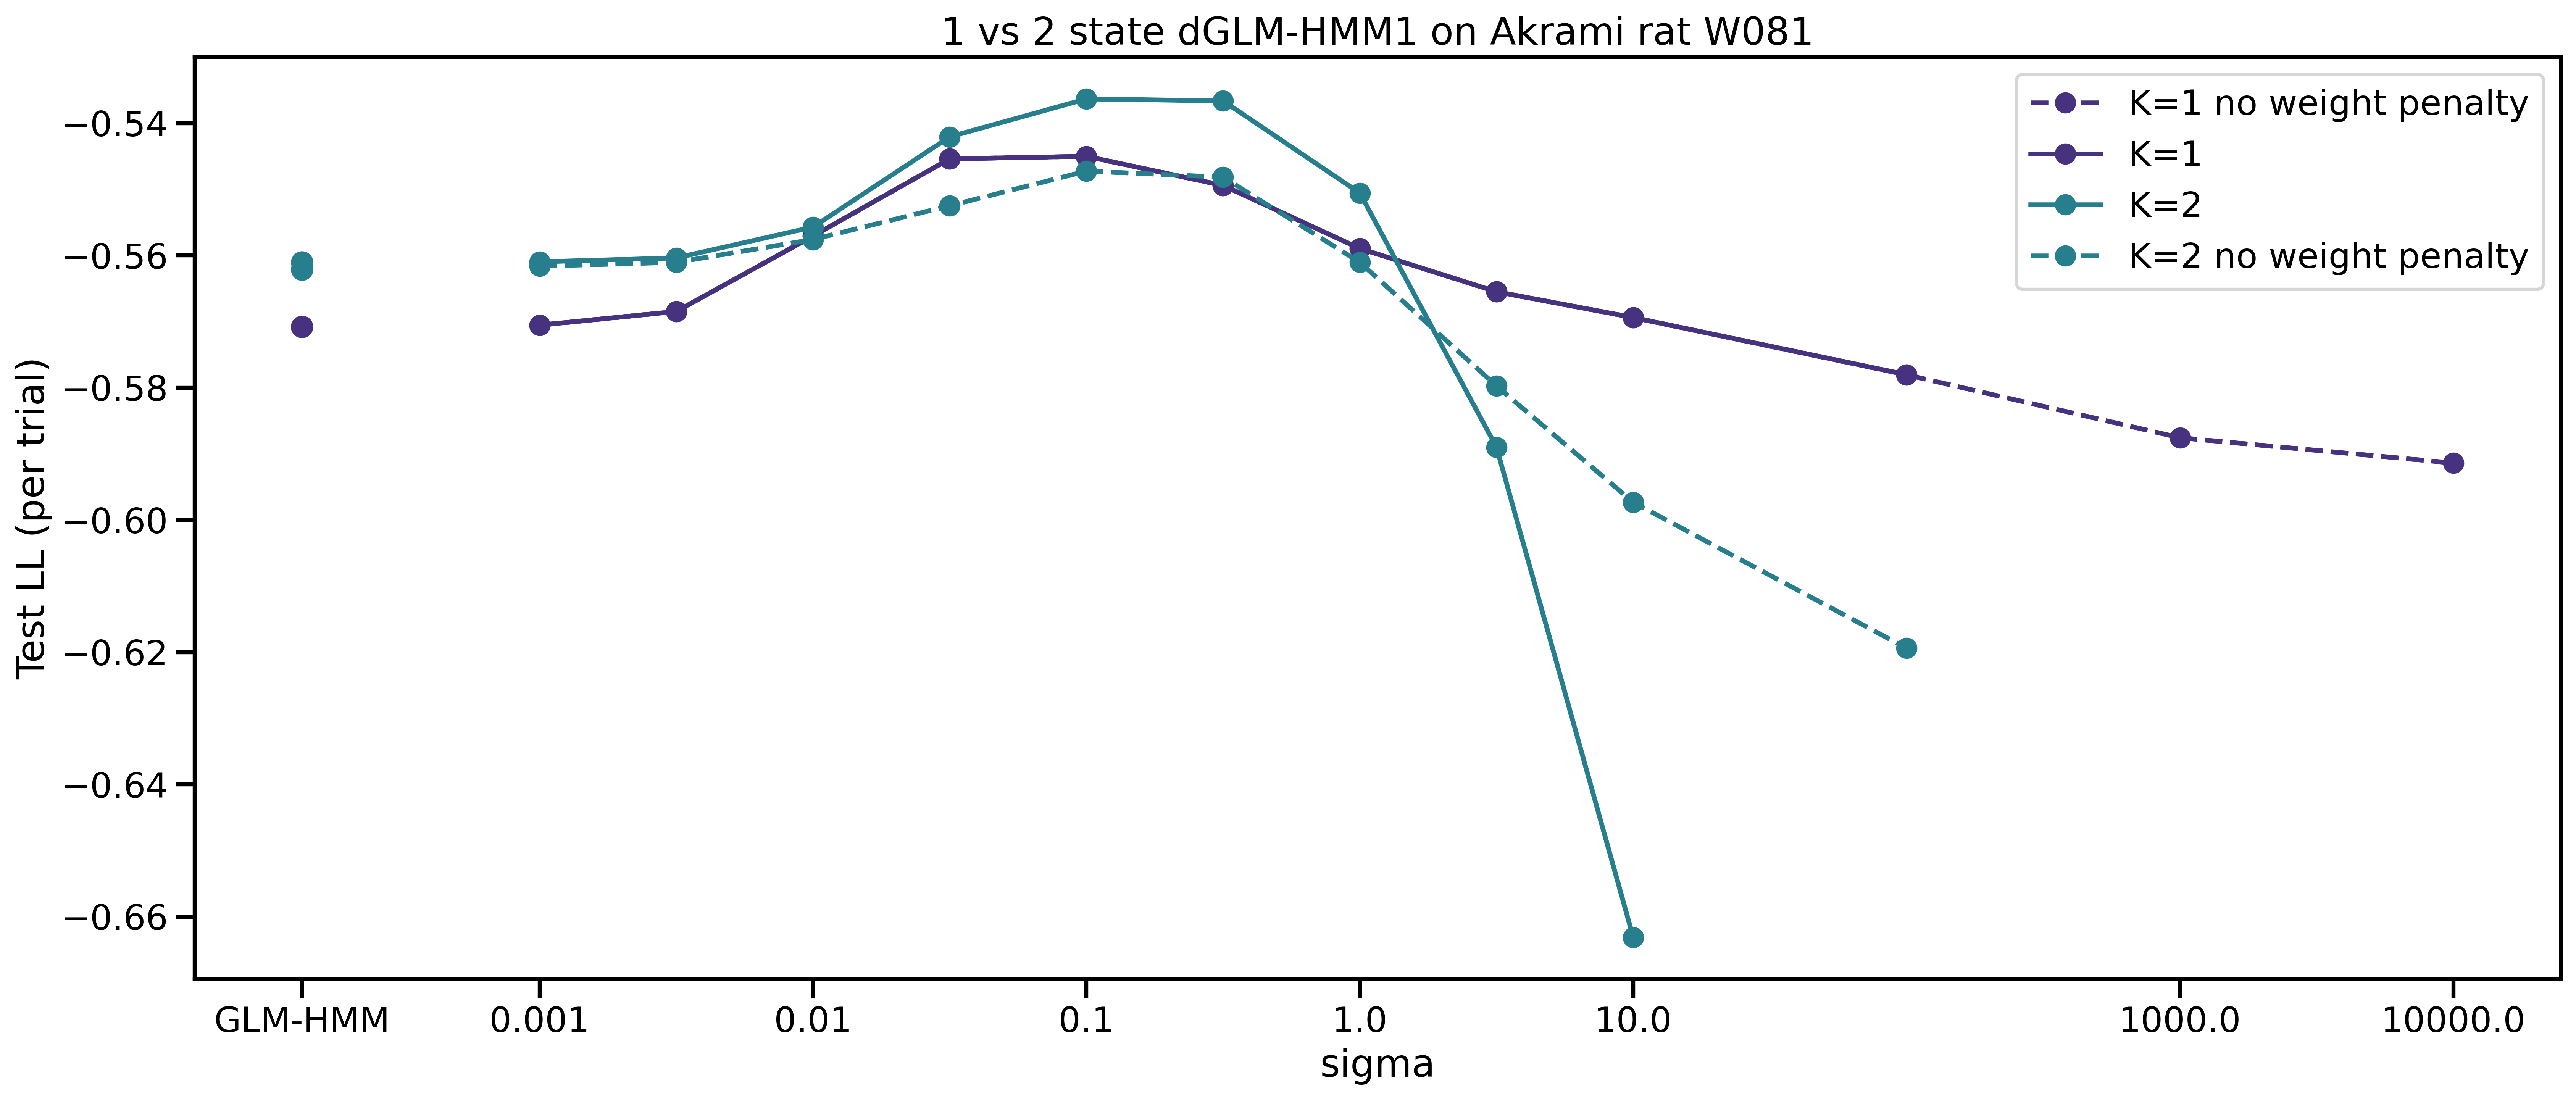

In [6]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat W081', labels=['K=1 no weight penalty'], color=0, linestyle='dashed', penaltyW=False, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat W081', labels=['K=1'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat W081', labels=['K=2'], color=2, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat W081', labels=['K=2 no weight penalty'], color=2, linestyle='dashed', penaltyW=False, save_fig=True)

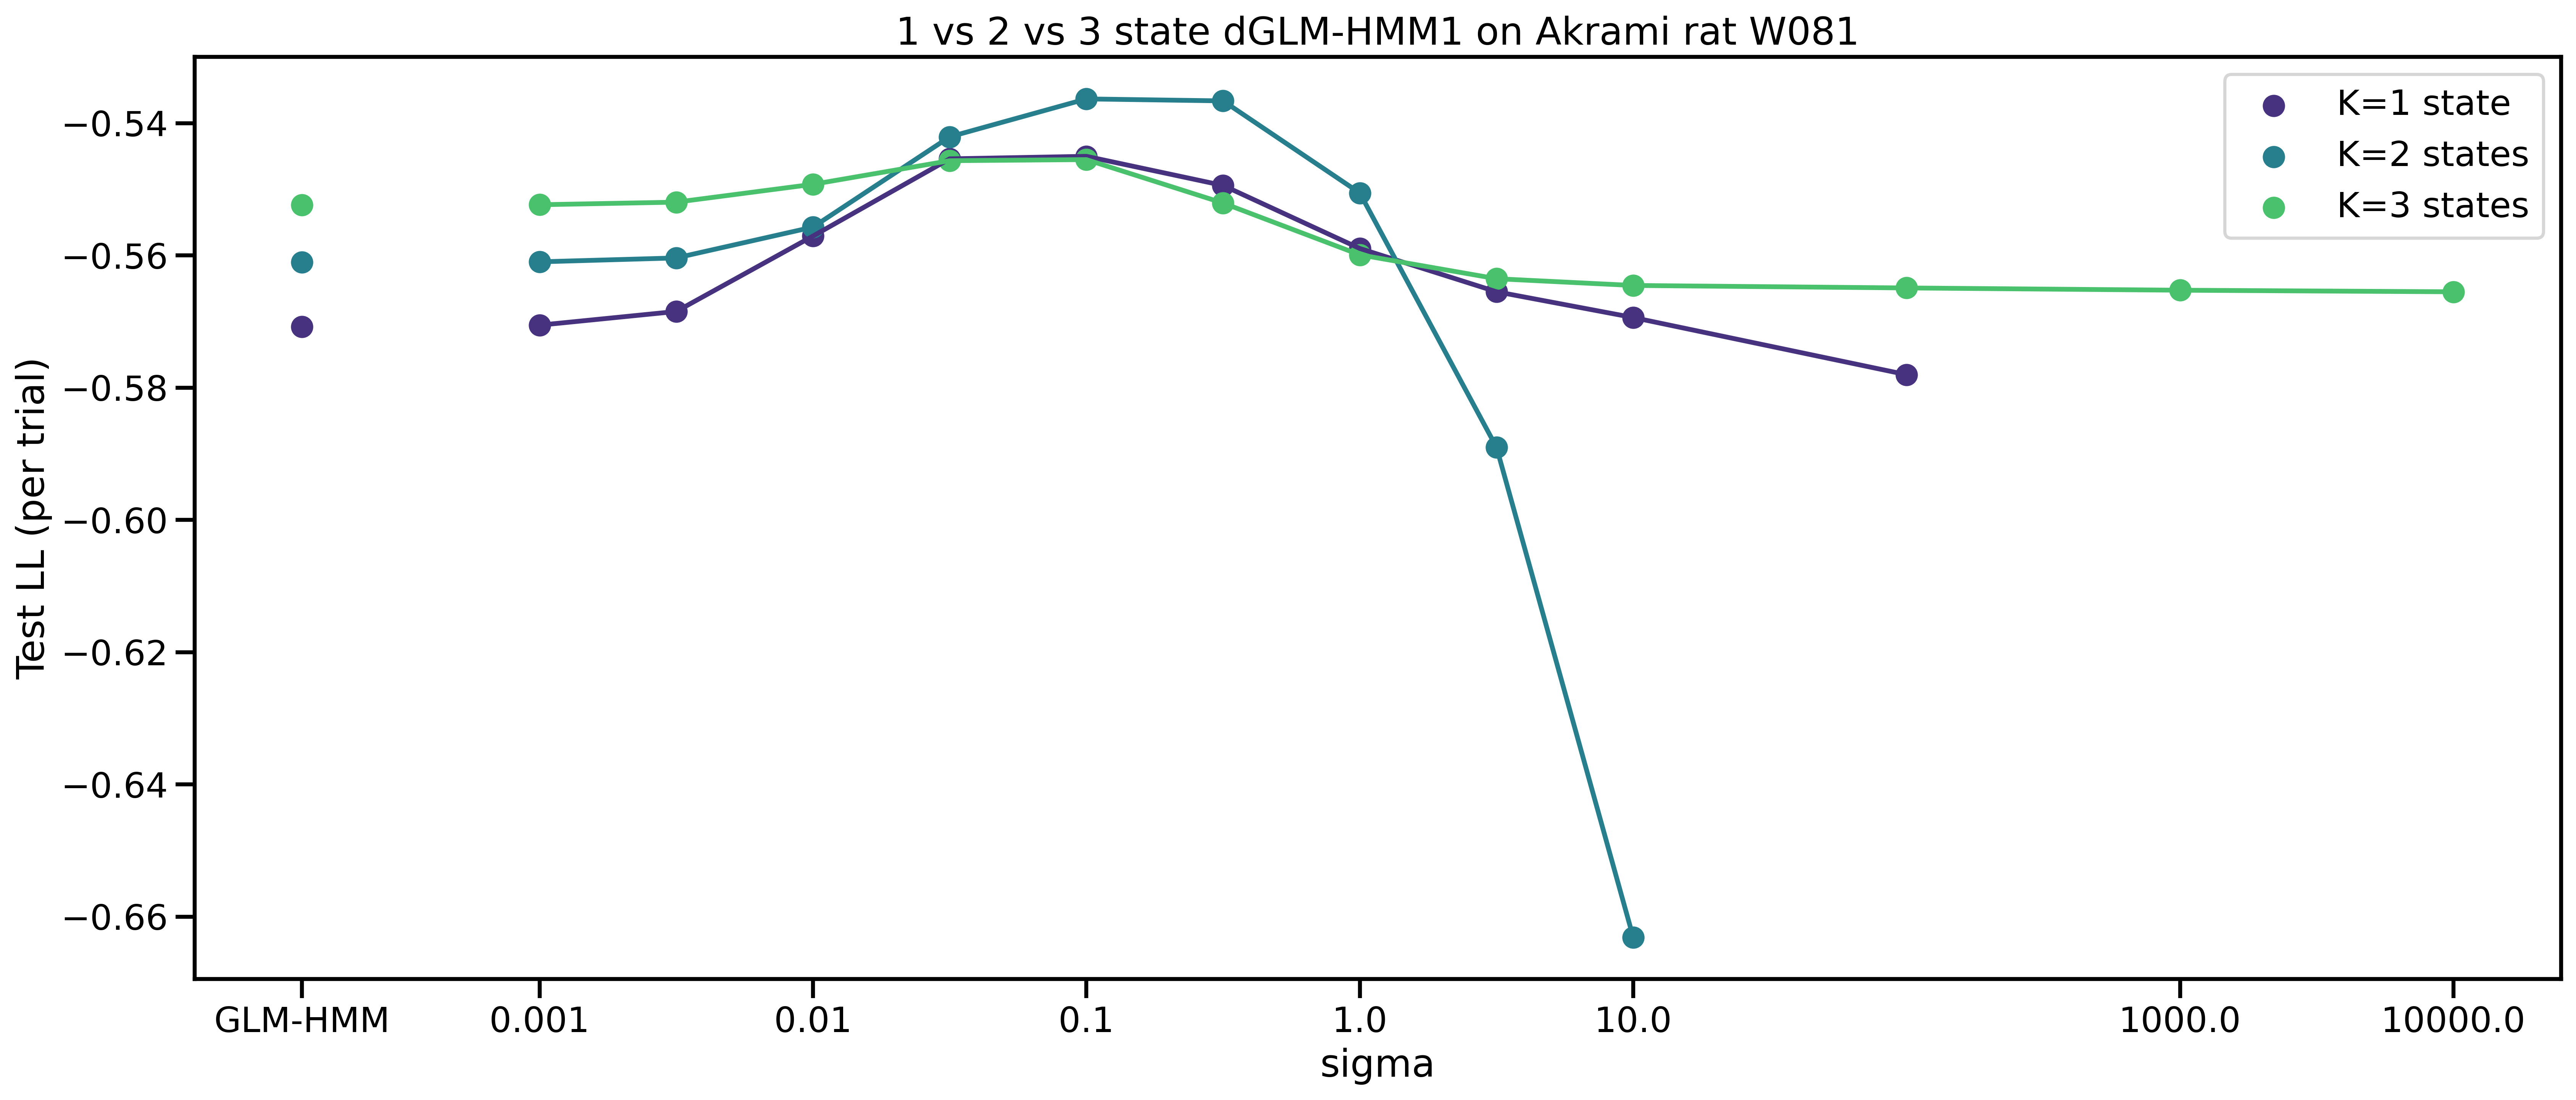

In [32]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 vs 3 state dGLM-HMM1 on Akrami rat W081', labels=['K=1 state'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 vs 3 state dGLM-HMM1 on Akrami rat W081', labels=['K=2 states'], color=2, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=3, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 vs 3 state dGLM-HMM1 on Akrami rat W081', labels=['K=3 states'], color=4, penaltyW=True, save_fig=True)

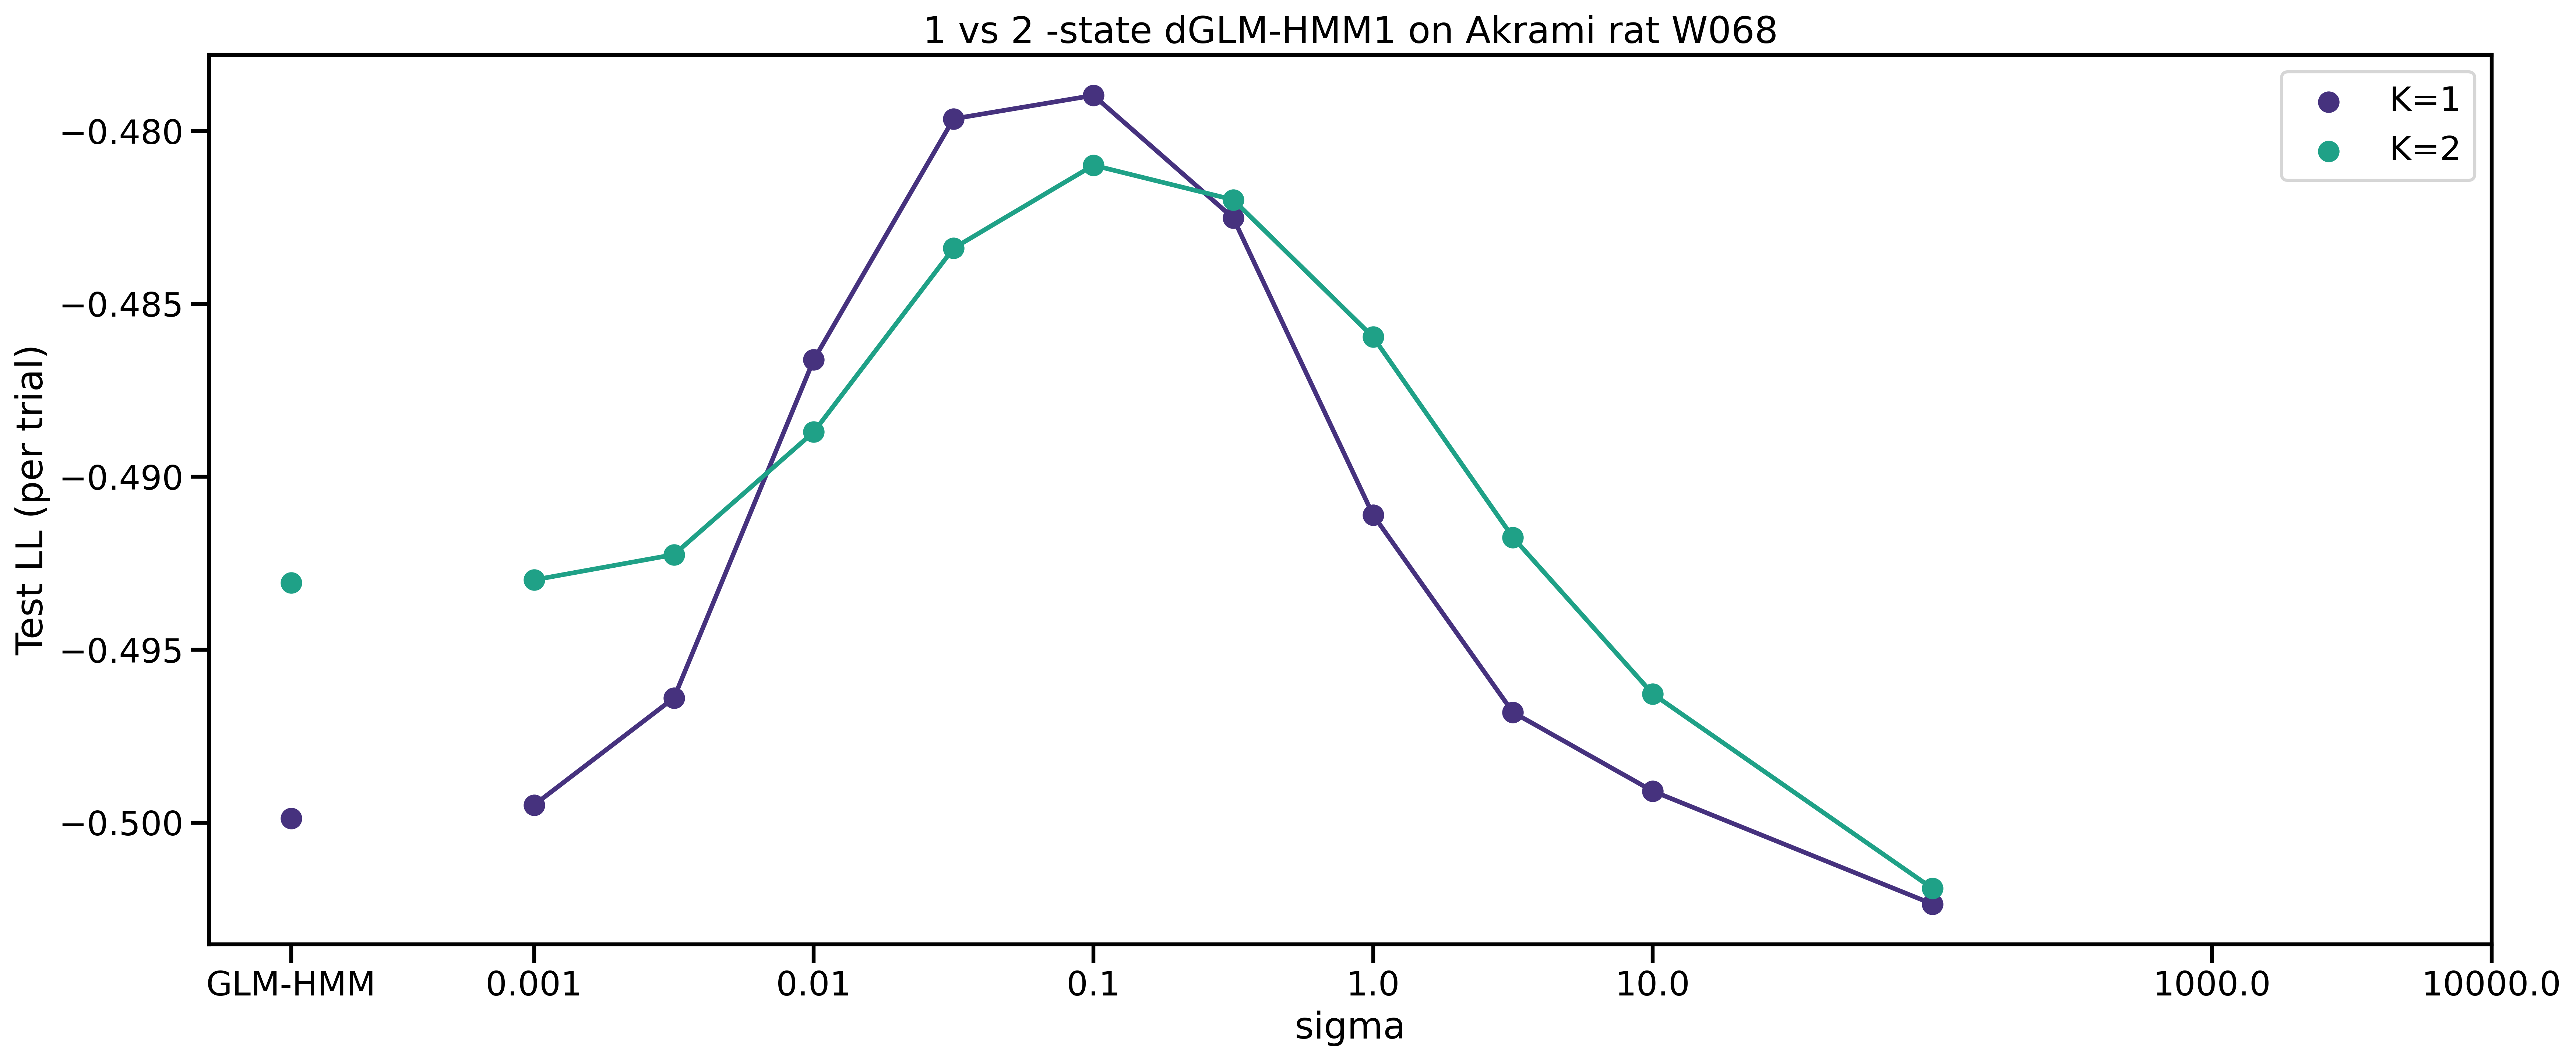

In [29]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W068', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W068', labels=['K=1'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W068', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W068', labels=['K=2'], color=3, penaltyW=True, save_fig=False)

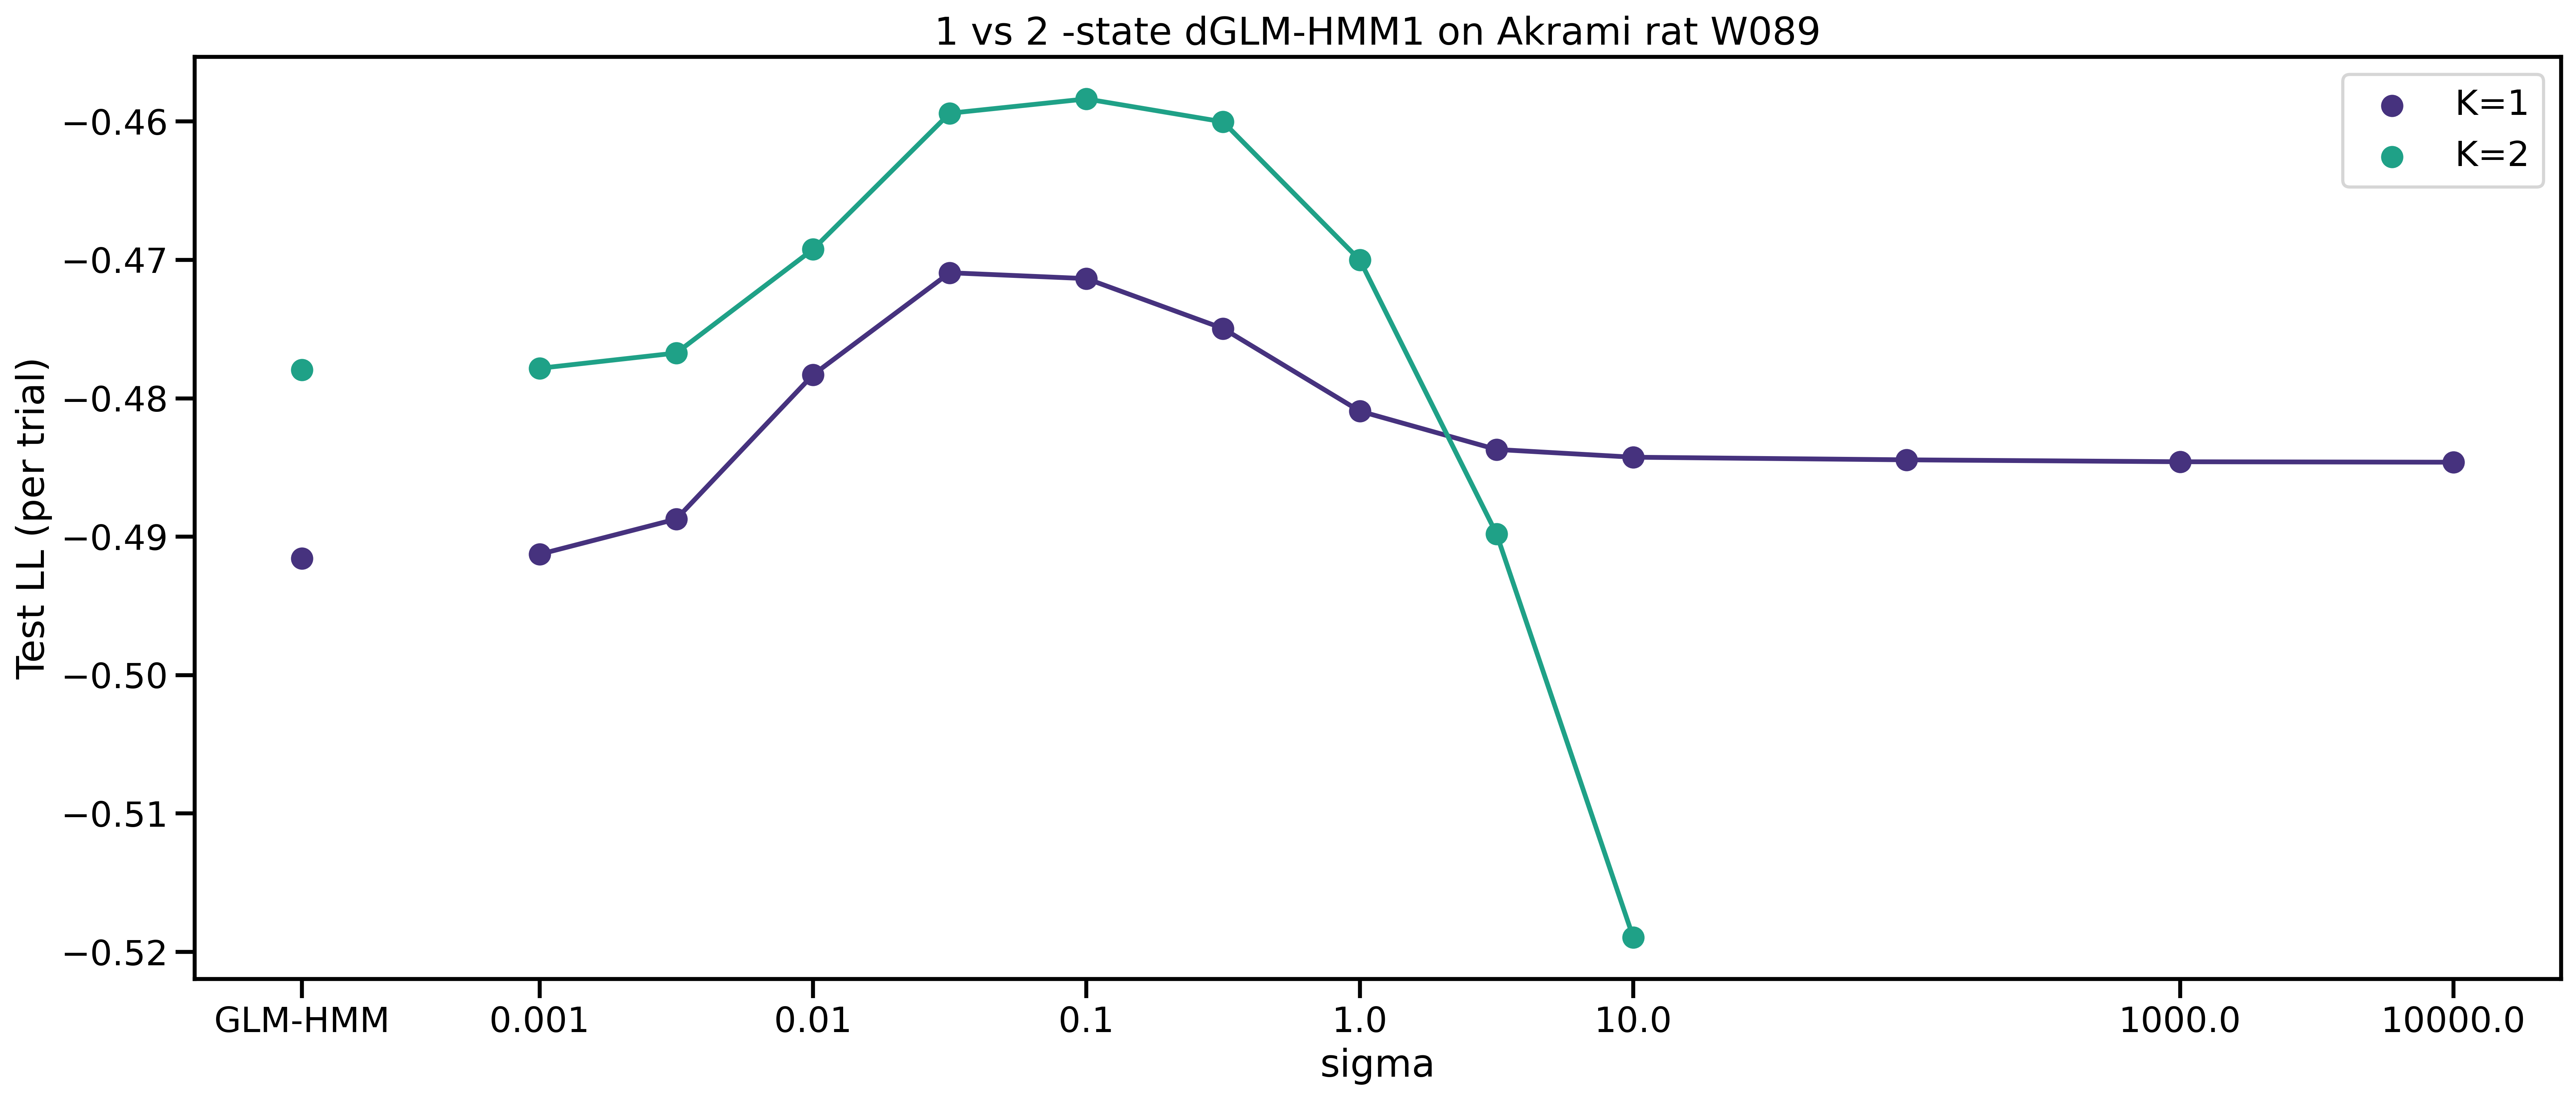

In [30]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W089', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W089', labels=['K=1'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W089', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W089', labels=['K=2'], color=3, penaltyW=True, save_fig=False)

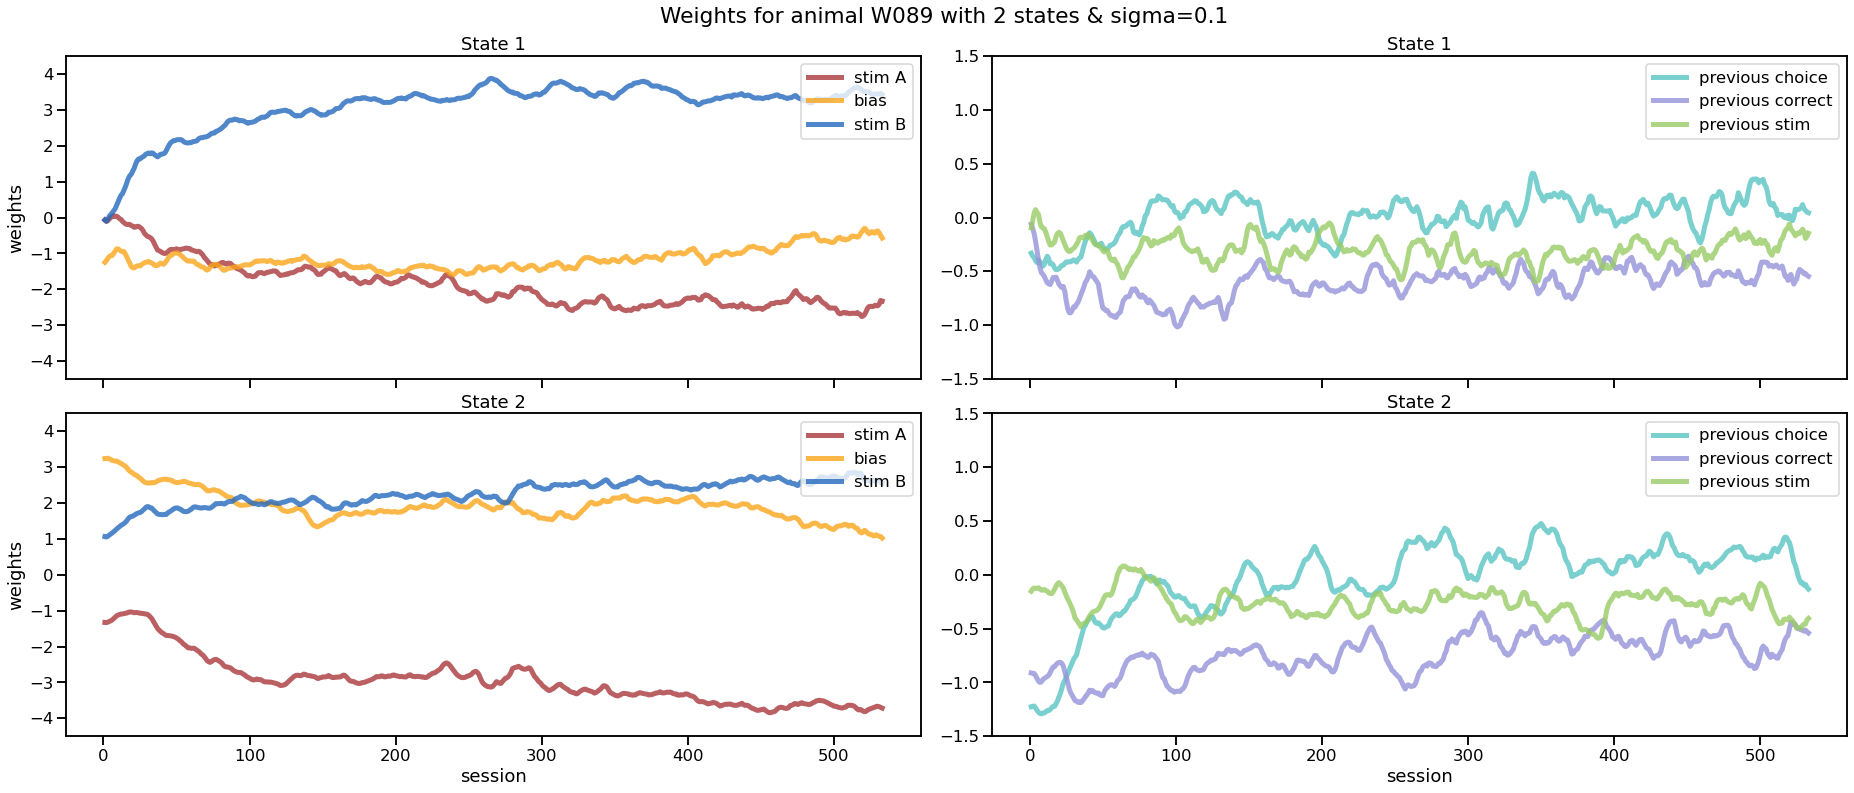

In [59]:
rat_id = 'W089'
stage_filter = 3
folds = 4
K = 2
penaltyW = True
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# PLOTTING WEIGHTS ACROSS MULTIPLE SIGMAS
for fold in range(0,1):
    trainSessInd = np.load(f'../data_PWM/trainSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    indSigma = 5
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(26,11))
    fig.suptitle(f'Weights for animal {rat_id} with {K} states & sigma={np.round(sigmaList[indSigma],4)}')
    fig.tight_layout()
    axes[0,0].set_ylim(-4.5,4.5)
    axes[1,0].set_ylim(-4.5,4.5)
    axes[0,1].set_ylim(-1.5,1.5)
    axes[1,1].set_ylim(-1.5,1.5)
    plotting_weights_PWM(w=allW[indSigma], sessInd=trainSessInd, axes=axes, sessStop=None, title=f'Weights for animal {rat_id} with {K} states & sigma={np.round(sigmaList[indSigma],4)}', save_fig=True)

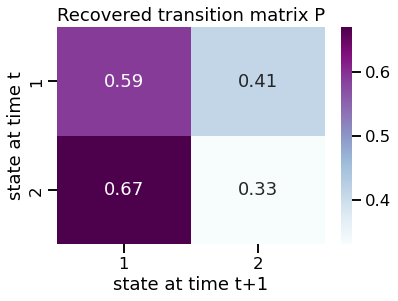

In [60]:
rat_id = 'W089'
stage_filter = 3
folds = 4
K = 2
penaltyW = True
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# PLOTTING Transition matrix P
for fold in range(0,1):
    allP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    indSigma = 5
    s = sns.heatmap(np.round(allP[indSigma],2),annot=True,cmap='BuPu', fmt='g')
    s.set(xlabel='state at time t+1', ylabel='state at time t', title='Recovered transition matrix P', xticklabels=[1,2], yticklabels=[1,2])
    fig = s.get_figure()
    

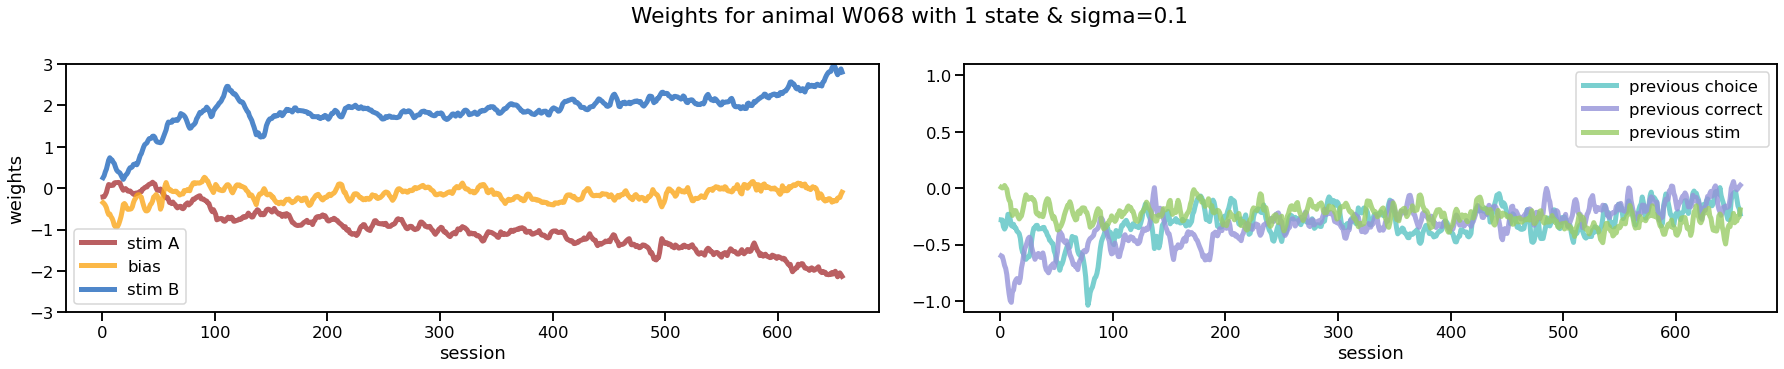

In [29]:
rat_id = 'W068'
stage_filter = 3
folds = 4
K = 1
penaltyW = True
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# PLOTTING WEIGHTS ACROSS MULTIPLE SIGMAS
for fold in range(0,1):
    trainSessInd = np.load(f'../data_PWM/trainSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    testSessInd = np.load(f'../data_PWM/testSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    indSigma = 5
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(25,5))
    axes[0].set_ylim(-3,3)
    axes[1].set_ylim(-1.1,1.1)
    fig.suptitle(f'Weights for animal {rat_id} with {K} state & sigma={np.round(sigmaList[indSigma],4)}')
    fig.tight_layout()
    plotting_weights_PWM(w=allW[indSigma], sessInd=trainSessInd, axes=axes, sessStop=None, title=f'Weights for animal {rat_id} with {K} state & sigma={np.round(sigmaList[indSigma],4)}', save_fig=True)
       

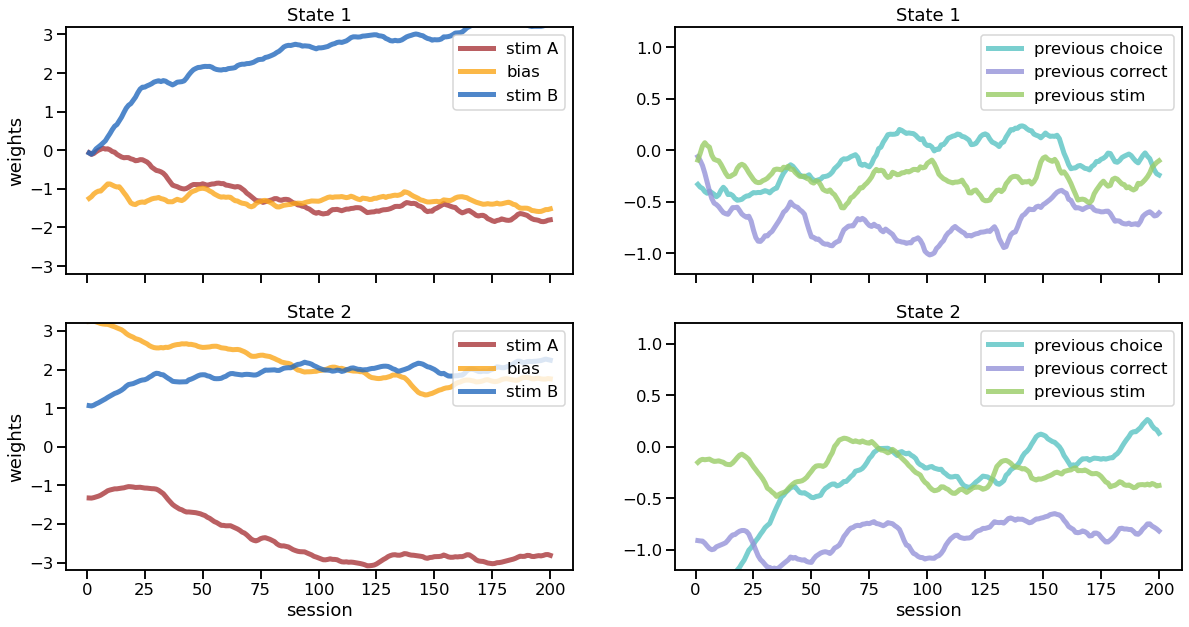

In [20]:
rat_id = 'W089'
stage_filter = 3
folds = 4
K = 2
penaltyW = True
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# PLOTTING WEIGHTS ACROSS MULTIPLE SIGMAS
for fold in range(0,1):
    trainSessInd = np.load(f'../data_PWM/trainSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    testSessInd = np.load(f'../data_PWM/testSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    indSigma = 5
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(20,10))
    axes[0,0].set_ylim(-3.2,3.2)
    axes[1,0].set_ylim(-3.2,3.2)
    axes[0,1].set_ylim(-1.2,1.2)
    axes[1,1].set_ylim(-1.2,1.2)
    plotting_weights_PWM(w=allW[indSigma], sessInd=trainSessInd, axes=axes, sessStop=200, title=f'PWM {rat_id} - {K} state, sigma={np.round(sigmaList[indSigma],4)}', save_fig=False)
       